## 📘 **SOMMAIRE DÉTAILLÉ POUR LE PRÉTRAITEMENT DU DATASET LUNA16**

---

### **1. Chargement et conversion des données**

- Lire les fichiers d’images médicales au format `.mhd` et `.raw`.
- Convertir les images en tableaux numériques (NumPy) pour le traitement.
- Associer chaque image à ses métadonnées (dimensions, espacement entre voxels, etc.).

---

### **2. Nettoyage des données**

- **Suppression des valeurs extrêmes** : Certains voxels peuvent contenir des valeurs aberrantes (comme -2000 HU), à remplacer ou ignorer.
- **Clipping des intensités** : Restreindre les valeurs à une plage utile pour les tissus pulmonaires, généralement entre **1200 HU et +600 HU**.

---

### **3. Normalisation de l’intensité**

- Échelle linéaire des valeurs de Hounsfield Units (HU) vers une plage de [0, 1] ou [-1, 1].
- Cela permet d’uniformiser les contrastes d’images pour l’apprentissage automatique.

---

### **4. Segmentation des poumons**

Objectif : isoler uniquement les deux poumons, en supprimant les autres tissus (côtes, cœur, muscles...).

- Appliquer un **seuil HU** (ex. -600) pour extraire les régions aérées.
- Utiliser des **méthodes morphologiques** (érosion, dilatation) pour nettoyer le masque.
- Sélectionner les **deux plus grandes zones connexes** comme étant les poumons.
- **Remplir les trous internes** pour ne pas perdre d’information.

---

### **5. Normalisation spatiale**

- Convertir toutes les images en une **résolution isotrope** standard : généralement **1 mm × 1 mm × 1 mm**.
- Cela consiste à **redimensionner** les voxels selon les métadonnées d’espacement.
- Résultat : des volumes homogènes d’un patient à l’autre.

---

### **6. Extraction de patches 3D ou 2D**

- Découper des **sous-volumes cubiques** centrés sur les nodules pulmonaires (ex. 32×32×32 ou 64×64×64 voxels).
- Extraire aussi des zones négatives (sans nodules) pour entraîner la distinction entre "nodule" et "non-nodule".
- Pour l’approche 2D : extraire des tranches axiales, sagittales ou coronales.

---

### **7. Augmentation de données (Data Augmentation)**

- Rotation aléatoire (3D ou 2D).
- Translation, zoom, miroir (flip horizontal ou vertical).
- Ajout de bruit gaussien ou variation de contraste.
- Objectif : augmenter la diversité des données pour éviter l’overfitting.

---

### **8. Préparation des labels / annotations**

- Charger les fichiers `annotations.csv` et `candidates_V2.csv`.
- Mapper les **coordonnées réelles des nodules** aux bons volumes ou slices.
- Générer les masques ou labels binaires pour chaque patch/image.

---

### **9. Gestion du déséquilibre des classes**

- Il y a **beaucoup plus de non-nodules** que de nodules.
- Stratégies possibles :
    - Suréchantillonnage des nodules.
    - Sous-échantillonnage des négatifs.
    - Utilisation de **pondération des classes** dans la loss function.

---

### **10. Division du dataset pour l’entraînement**

- Appliquer une **validation croisée à 10 plis (10-fold cross-validation)** comme recommandé par LUNA16.
- S’assurer qu’il n’y ait pas de chevauchement entre les patients dans les sets d’entraînement/test.
- Optionnel : réserver un ensemble pour une évaluation finale indépendante.

---

### **11. Évaluation des modèles**

- Suivre les métriques utilisées par LUNA16 :
    - **Sensibilité (Recall)**
    - **Faux positifs par scan (FP/scan)**
    - **Courbe FROC (Free-Response ROC)**
- Générer des courbes ROC/FROC après l’inférence pour comparer les performances.

## 🔍 **Sur quoi s’appuie ce sommaire ?**

Ce sommaire est construit à partir de plusieurs **sources fiables et spécialisées** dans l’analyse du dataset **LUNA16**, notamment :

### 📚 **1. La documentation officielle du challenge LUNA16**

- Recommandations du LUNA16 Grand Challenge.
- Description de la structure des données et des étapes de preprocessing recommandées.
- Notamment l'utilisation de la **10-fold cross-validation** et l’objectif de **détection automatique de nodules pulmonaires**.

### 🧪 **2. Articles de recherche / papiers scientifiques**

- Par exemple :
    - **"Automated Pulmonary Nodule Detection in CT Images: A Survey"**.
    - **"DeepLung: 3D Deep Convolutional Nets for Automated Pulmonary Nodule Detection and Classification"**.
    - **"A Survey of Deep Learning for Lung Nodule Detection and Classification" (2020)**.

> Ces travaux décrivent des pipelines incluant la segmentation des poumons, la normalisation HU, la conversion isotrope, l’extraction de patchs, etc.
>

### 🔧 **3. Projets open source et tutoriels GitHub utilisés en Deep Learning médical**

- Beaucoup de chercheurs publient leur pipeline complet :
    - Prétraitement `.mhd`
    - Segmentation + normalisation + resample
    - Export en `.npy`, `.h5`, ou `.nii.gz` pour entraînement.

---

## 📦 **Format d’entrée & de sortie :**

### ✅ **Format d’entrée (original LUNA16)** :

- Fichiers **`.mhd`** (MetaImage) + `.raw`
- Ce sont des **scans 3D volumétriques** de patients
- Contiennent des **métadonnées** :
    - Dimensions, espacement entre voxels, orientation

### 🔁 **Format de sortie après nettoyage (au choix selon l’usage)** :

| Usage visé | Format de sortie courant | Détail |
| --- | --- | --- |
| Pour traitement rapide (patch) | `.npy` | Tableau NumPy de patchs extraits ou volumes normalisés |
| Pour segmentation 3D | `.nii.gz` (NIfTI) | Format compatible avec outils médicaux (3D Slicer, etc.) |
| Pour entraînement patch 2D | `.png`, `.jpg` ou `.npy` | Tranches (slices) individuelles 2D normalisées |
| Pour deep learning complet | `.h5` (HDF5) | Pour stocker images + labels dans un fichier unique |

> ⚠️ Le .mhd n’est souvent plus utilisé après le nettoyage complet, car on le convertit en un format plus léger et plus rapide à lire pour l’IA.
>

---

### 💡 Exemple typique de workflow :

1. Lecture `.mhd` + `.raw`
2. Segmentation poumon → masque
3. Application du masque sur le volume
4. Normalisation HU → [0,1]
5. Conversion isotrope
6. Sauvegarde finale : `volume_clean.npy` ou `patches_clean.npy`

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from google.colab import drive

# 1. Monter Google Drive
drive.mount('/content/drive')

# 2. Créer un dossier temporaire pour le téléchargement
os.makedirs("/content/luna_temp", exist_ok=True)
os.chdir("/content/luna_temp")

# 3. Télécharger subset0 depuis Zenodo
!wget https://zenodo.org/record/3723295/files/subset0.zip

# 4. Décompresser le zip
!unzip -q subset0.zip

# 5. Déplacer vers ton Drive (changer le chemin si besoin)
target_path = "/content/drive/MyDrive/luna16_data/subset0"
os.makedirs(target_path, exist_ok=True)

!mv subset0/* "$target_path"

print("✅ subset0 téléchargé et déplacé vers Google Drive !")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2025-04-15 22:55:39--  https://zenodo.org/record/3723295/files/subset0.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3723295/files/subset0.zip [following]
--2025-04-15 22:55:40--  https://zenodo.org/records/3723295/files/subset0.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6811924508 (6.3G) [application/octet-stream]
Saving to: ‘subset0.zip’

subset0.zip         100%[===================>]   6.34G  23.0MB/s    in 4m 52s  

2025-04-15 23:00:32 (22.3 MB/s) - ‘subset0.zip’ saved [6811924508/6811924508]

✅ subset0 téléchargé et déplacé vers Google Drive !


In [ ]:
!pip install SimpleITK


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 8.6 MB/s eta 0:00:00


In [ ]:
pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.2 MB/s eta 0:00:00


##📘 1. Chargement et visualisation initiale du volume LUNA16 (.mhd)##

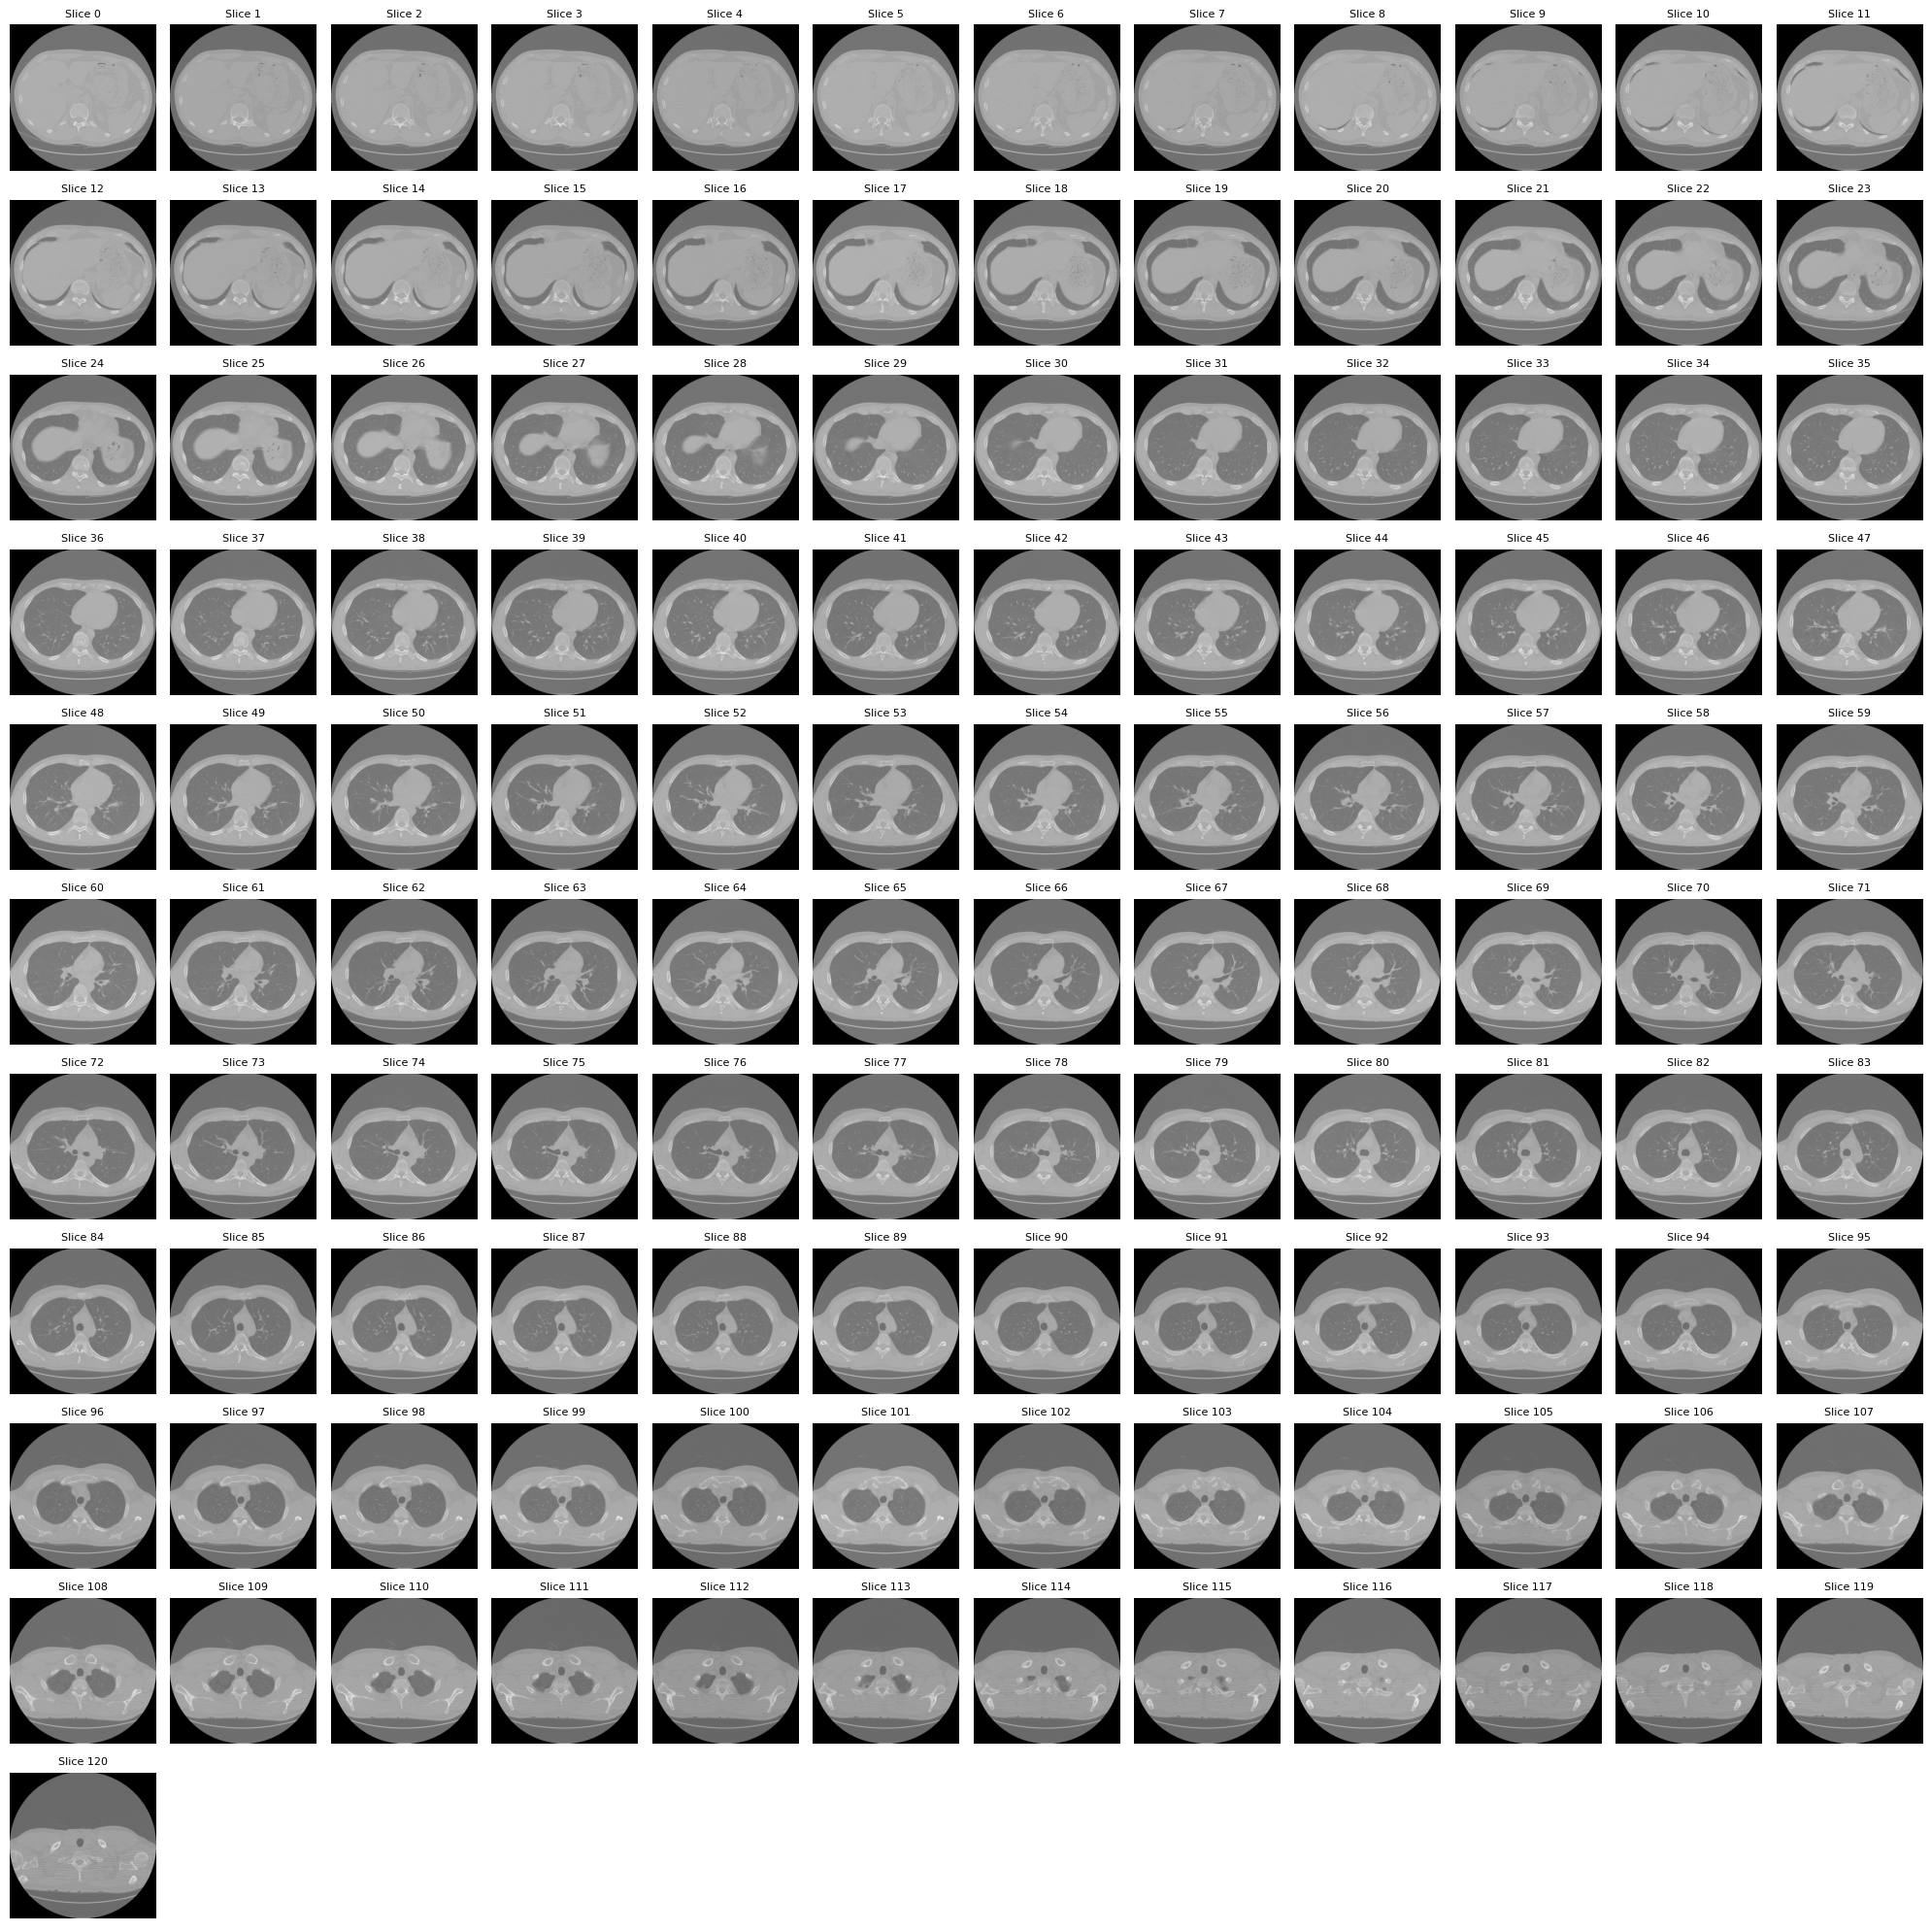

In [ ]:
import math
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# volume contient déjà les slices : shape = (120, H, W)
num_slices = volume.shape[0]

# Définir les dimensions de la grille (par ex. 12x10)
cols = 12
rows = math.ceil(num_slices / cols)

fig, axs = plt.subplots(rows, cols, figsize=(20, 20))

# Boucle pour remplir la grille
for i in range(rows * cols):
    row = i // cols
    col = i % cols

    ax = axs[row, col]
    if i < num_slices:
        ax.imshow(volume[i], cmap='gray')
        ax.set_title(f"Slice {i}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

**🧠  Matching entre annotations.csv et candidates.csv**

##📁 Sélection et copie des 40 *premiers* scans de subset0##

Ce bloc de code permet de préparer un sous-ensemble de 40 scanners thoraciques (CT scans) à partir du dossier subset0 fourni par le dataset LUNA16. Tout d’abord, le script crée un nouveau dossier de destination nommé subset0_40, s’il n’existe pas déjà. Ensuite, il liste tous les fichiers .mhd (qui contiennent les métadonnées des images médicales) présents dans le dossier source, les trie, puis en sélectionne les 40 premiers. Pour chaque fichier .mhd sélectionné, le script copie également le fichier .raw associé (qui contient les données volumétriques réelles du scanner).  À la fin de l’exécution, les 40 scanners sont prêts dans un répertoire dédié (subset0_40), facilitant ainsi le traitement futur (prétraitement, segmentation, etc.) tout en réduisant le volume de données pour les expérimentations initiales.

In [ ]:
import os
import shutil

source_folder = "/content/drive/MyDrive/luna16_data/subset0"
dest_folder = "/content/drive/MyDrive/luna16_data/subset0_40"

# Créer le dossier de destination s’il n’existe pas
os.makedirs(dest_folder, exist_ok=True)

# Lister uniquement les fichiers .mhd
mhd_files = sorted([f for f in os.listdir(source_folder) if f.endswith(".mhd")])

# Vérifie le total
print(f"Total .mhd dans subset0 : {len(mhd_files)}")

# Copier les 40 premiers
for f in mhd_files[:40]:
    mhd_path = os.path.join(source_folder, f)
    raw_path = mhd_path.replace(".mhd", ".raw")  # On suppose qu’il a un .raw associé

    shutil.copy(mhd_path, dest_folder)
    if os.path.exists(raw_path):
        shutil.copy(raw_path, dest_folder)
    else:
        print(f"⚠️ Fichier .raw manquant pour {f}")

print("✅ Copie des 40 CT scans terminée.")

Total .mhd dans subset0 : 89
⚠️ Fichier .raw manquant pour 1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411.mhd
⚠️ Fichier .raw manquant pour 1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820.mhd
✅ Copie des 40 CT scans terminée.


Ce code a pour but de faire correspondre les annotations manuelles des nodules pulmonaires (issues du fichier annotations.csv) avec les candidats potentiels détectés automatiquement (contenus dans candidates.csv). Pour chaque annotation, on recherche les candidats appartenant au même scanner (seriesuid) et situés à proximité dans l’espace (moins de 10 mm d’écart sur les coordonnées X, Y et Z). Si un ou plusieurs candidats satisfont ces critères de proximité, ils sont considérés comme des correspondances valides (matching). L’ensemble des correspondances identifiées est ensuite fusionné dans un tableau unique (matching_df) qui est sauvegardé dans un fichier CSV nommé matching_candidates.csv. Ce fichier contient donc uniquement les candidats spatialement proches des annotations réelles, ce qui permet de constituer un jeu de données supervisé fiable pour l'entraînement d’un modèle de détection de nodules.

# Partie 1 : Prétraitement


**✅ ÉTAPE 1 — Conversion .mhd → .npy + sauvegarde des métadonnées**


🎯 But : simplifier et accélérer le traitement des images
Les fichiers .mhd sont des formats médicaux volumétriques (3D) utilisés en hôpital.

Ils sont lents à lire et lourds à manipuler à chaque étape de prétraitement ou entraînement.

Le format .npy (NumPy) est :

✔️ plus rapide à charger

✔️ plus facile à traiter avec PyTorch, TensorFlow, etc.

✔️ compatible avec les opérations NumPy (normalisation, patch extraction, etc.)

✅ Conclusion : on ne modifie pas les données, on les convertit en un format plus rapide à manipuler pour tout le pipeline IA.

In [ ]:
import os
import SimpleITK as sitk
import numpy as np

# === 1. Dossier source des .mhd ===
input_dir = "/content/drive/MyDrive/luna16_data/subset0"

# === 2. Dossier de sortie pour les .npy et les métadonnées ===
output_dir = "step1_numpy_volumes"
os.makedirs(output_dir, exist_ok=True)

# === 3. Parcourir tous les fichiers .mhd ===
for filename in os.listdir(input_dir):
    if filename.endswith(".mhd"):
        filepath = os.path.join(input_dir, filename)
        print(f"📥 Chargement de : {filename}")

        try:
            # === Lire l'image avec SimpleITK ===
            itk_image = sitk.ReadImage(filepath)

            # === Convertir en tableau NumPy (Z, Y, X) ===
            image_array = sitk.GetArrayFromImage(itk_image)

            # === Extraire les métadonnées ===
            spacing = itk_image.GetSpacing()       # (x, y, z)
            origin = itk_image.GetOrigin()         # (x, y, z)
            direction = itk_image.GetDirection()   # orientation

            # === Préparer le nom du fichier (sans extension) ===
            base_name = filename.replace(".mhd", "")

            # === Sauvegarder le volume en .npy ===
            np.save(os.path.join(output_dir, base_name + ".npy"), image_array)

            # === Sauvegarder les métadonnées en .npz (compressé) ===
            np.savez_compressed(os.path.join(output_dir, base_name + "_meta.npz"),
                                spacing=spacing, origin=origin, direction=direction)

        except Exception as e:
            print(f"❌ Erreur lors du chargement de {filename} : {e}")
            continue

print("✅ Conversion terminée.")


📥 Chargement de : 1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865.mhd
📥 Chargement de : 1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231.mhd
📥 Chargement de : 1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.mhd
📥 Chargement de : 1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430.mhd
📥 Chargement de : 1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767.mhd
📥 Chargement de : 1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831.mhd
📥 Chargement de : 1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.mhd
📥 Chargement de : 1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd
📥 Chargement de : 1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663.mhd
📥 Chargement de : 1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827.mhd
📥 Chargement de : 1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495.mhd
📥 Chargement de : 1.3.6.1.4.1.14519.5.2.1.6

In [ ]:
import os
import glob

subset_path = '/content/drive/MyDrive/luna16_data/subset0_filtered_40'
mhd_files = glob.glob(os.path.join(subset_path, '*.mhd'))

# Garde uniquement ceux qui ont aussi un .raw correspondant
valid_mhd_files = [f for f in mhd_files if os.path.exists(f.replace('.mhd', '.raw'))]

print(f"Nombre de fichiers .mhd valides (avec .raw) : {len(valid_mhd_files)}")


Nombre de fichiers .mhd valides (avec .raw) : 40


In [ ]:
import os
import shutil
import pandas as pd

# --- Paths ---
csv_path = "/content/drive/MyDrive/luna16_data/matching_candidates.csv"
subset0_path = "/content/drive/MyDrive/luna16_data/subset0"
output_subset_path = "/content/luna_temp/subset0_filtered_40"

# --- Charger les données ---
candidates_df = pd.read_csv(csv_path)

# --- Récupérer tous les seriesuid uniques ---
all_seriesuids = candidates_df["seriesuid"].unique()

# --- Filtrer ceux qui existent physiquement dans subset0 ---
existing_seriesuids = [
    uid for uid in all_seriesuids
    if os.path.exists(os.path.join(subset0_path, f"{uid}.mhd"))
]

print(f"{len(existing_seriesuids)} seriesuid avec fichiers .mhd trouvés dans subset0.")

# --- Sélectionner les 40 premiers valides ---
selected_seriesuids = existing_seriesuids[:40]
print(f"Nombre de séries sélectionnées : {len(selected_seriesuids)}")

# --- Créer le dossier de sortie ---
os.makedirs(output_subset_path, exist_ok=True)

# --- Copier les fichiers .mhd et .raw correspondants ---
for uid in selected_seriesuids:
    for ext in [".mhd", ".raw"]:
        src = os.path.join(subset0_path, f"{uid}{ext}")
        dst = os.path.join(output_subset_path, f"{uid}{ext}")
        if os.path.exists(src):
            shutil.copy(src, dst)
        else:
            print(f"Fichier manquant : {src}")

print(f"\n✅ Copie terminée : {len(selected_seriesuids)} fichiers .mhd + .raw copiés dans '{output_subset_path}'")


67 seriesuid avec fichiers .mhd trouvés dans subset0.
Nombre de séries sélectionnées : 40

✅ Copie terminée : 40 fichiers .mhd + .raw copiés dans '/content/luna_temp/subset0_filtered_40'


In [ ]:
import shutil
import os

source_dir = "/content/luna_temp/subset0_filtered_40"
destination_dir = "/content/drive/MyDrive/luna16_data/subset0_filtered_40"

# Créer le dossier de destination s'il n'existe pas
os.makedirs(destination_dir, exist_ok=True)

# Copier récursivement tout le contenu du dossier
shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

print(f"✅ Dossier copié vers : {destination_dir}")

# (Optionnel) Supprimer le dossier source après la copie
shutil.rmtree(source_dir)
print(f"🧹 Dossier source supprimé : {source_dir}")


✅ Dossier copié vers : /content/drive/MyDrive/luna16_data/subset0_filtered_40
🧹 Dossier source supprimé : /content/luna_temp/subset0_filtered_40


In [ ]:
import pandas as pd
import os

# Chemins
csv_path = "/content/drive/MyDrive/luna16_data/matching_candidates.csv"
subset_path = "/content/drive/MyDrive/luna16_data/subset0_filtered_40"
output_csv_path = "/content/drive/MyDrive/luna16_data/matching_candidates_filtered_40.csv"

# Charger le fichier CSV
candidates_df = pd.read_csv(csv_path)

# Extraire les seriesuid disponibles dans le dossier subset filtré
available_seriesuids = set([
    filename.replace(".mhd", "") for filename in os.listdir(subset_path) if filename.endswith(".mhd")
])

print(f"📦 SeriesUID disponibles (dans subset0_filtered_40): {len(available_seriesuids)}")

# Filtrer le DataFrame
filtered_df = candidates_df[candidates_df["seriesuid"].isin(available_seriesuids)]

# Sauvegarder le résultat
filtered_df.to_csv(output_csv_path, index=False)

print(f"✅ Fichier filtré sauvegardé : {output_csv_path}")
print(f"🔍 Candidats conservés : {len(filtered_df)}")

📦 SeriesUID disponibles (dans subset0_filtered_40): 40
✅ Fichier filtré sauvegardé : /content/drive/MyDrive/luna16_data/matching_candidates_filtered_40.csv
🔍 Candidats conservés : 142


In [ ]:
import os
import SimpleITK as sitk

# Chemin vers le dossier contenant les fichiers .mhd
subset_path = "/content/drive/MyDrive/luna16_data/subset0_filtered_40"

# Lister les fichiers .mhd
mhd_files = [f for f in os.listdir(subset_path) if f.endswith(".mhd")]

print(f"📂 Total des scans trouvés : {len(mhd_files)}\n")

# Initialiser le compteur de slices
total_slices = 0

# Parcourir chaque fichier et additionner le nombre de slices (profondeur Z)
for file in mhd_files:
    file_path = os.path.join(subset_path, file)
    image = sitk.ReadImage(file_path)
    size = image.GetSize()  # (X, Y, Z)
    slices = size[2]
    total_slices += slices
    print(f"{file}: {slices} slices")

# Afficher le total
print("\n🧮 Total de tous les slices dans les 40 scans :", total_slices)


📂 Total des scans trouvés : 40

1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767.mhd: 471 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495.mhd: 300 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223.mhd: 209 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd: 195 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd: 538 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd: 280 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd: 232 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd: 133 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd: 245 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.310548927038333190233889983845.mhd: 127 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.313605260055394498989743099991.mhd: 129 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd: 125 sli

📥 Chargement et conversion des images médicales en unités Hounsfield (HU)
Ce segment de code est responsable de l’importation des scans thoraciques (CT scans) au format médical à l’aide de la bibliothèque SimpleITK. La fonction load_scan(path) permet de lire une image DICOM au format .mhd, d’extraire les voxels sous forme d’un tableau NumPy 3D (img_array), et de récupérer les métadonnées importantes telles que l’origine (origin) et l’espacement entre les pixels (spacing).
Ensuite, la fonction get_pixels_hu(image) convertit les valeurs brutes de l’image en unités Hounsfield (HU), une échelle standard utilisée en imagerie médicale pour quantifier la densité des tissus. Les pixels avec une valeur de -2000 (correspondant à l’air extérieur) sont remplacés par zéro pour éviter les artefacts lors du traitement.

In [ ]:
import os
import SimpleITK as sitk
import numpy as np

# Dossier contenant les fichiers .mhd
data_path = "/content/drive/MyDrive/luna16_data/subset0_40"

# Liste tous les fichiers .mhd dans le dossier
mhd_files = [f for f in os.listdir(data_path) if f.endswith(".mhd")]

# Boucle sur chaque fichier
for filename in mhd_files:
    full_path = os.path.join(data_path, filename)

    # Lire l'image
    image = sitk.ReadImage(full_path)

    # Convertir en tableau NumPy (z, y, x)
    image_array = sitk.GetArrayFromImage(image)

    # Récupérer les métadonnées
    dimensions = image.GetSize()         # (x, y, z)
    spacing = image.GetSpacing()         # (x, y, z)

    # Tu peux aussi récupérer l'origin si besoin
    origin = image.GetOrigin()           # (x, y, z)

    # Afficher les infos
    print(f"\n📂 Scan : {filename}")
    print(f"🧩 Dimensions (x,y,z): {dimensions}")
    print(f"📏 Espacement entre voxels (x,y,z): {spacing}")
    print(f"📍 Origine (x,y,z): {origin}")
    print(f"🔢 Shape du tableau NumPy (z,y,x): {image_array.shape}")


📂 Scan : 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
🧩 Dimensions (x,y,z): (512, 512, 121)
📏 Espacement entre voxels (x,y,z): (0.7617189884185791, 0.7617189884185791, 2.5)
📍 Origine (x,y,z): (-198.100006, -195.0, -335.209991)
🔢 Shape du tableau NumPy (z,y,x): (121, 512, 512)

📂 Scan : 1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
🧩 Dimensions (x,y,z): (512, 512, 119)
📏 Espacement entre voxels (x,y,z): (0.7421879768371582, 0.7421879768371582, 2.5)
📍 Origine (x,y,z): (-182.5, -190.0, -313.75)
🔢 Shape du tableau NumPy (z,y,x): (119, 512, 512)

📂 Scan : 1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
🧩 Dimensions (x,y,z): (512, 512, 161)
📏 Espacement entre voxels (x,y,z): (0.5488280057907104, 0.5488280057907104, 1.25)
📍 Origine (x,y,z): (-187.699997, -108.300003, -194.0)
🔢 Shape du tableau NumPy (z,y,x): (161, 512, 512)

📂 Scan : 1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd
🧩 Dimensions (x,y,z): (

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK-build/ITK/Modules/IO/Meta/src/itkMetaImageIO.cxx:490:
ITK ERROR: MetaImageIO(0x13df0970): File cannot be read: /content/drive/MyDrive/luna16_data/subset0_40/1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411.mhd for reading.
Reason: No such file or directory

Shape (Z, Y, X): (119, 512, 512)
Origin: (-182.5, -190.0, -313.75)
Spacing: (0.7421879768371582, 0.7421879768371582, 2.5)


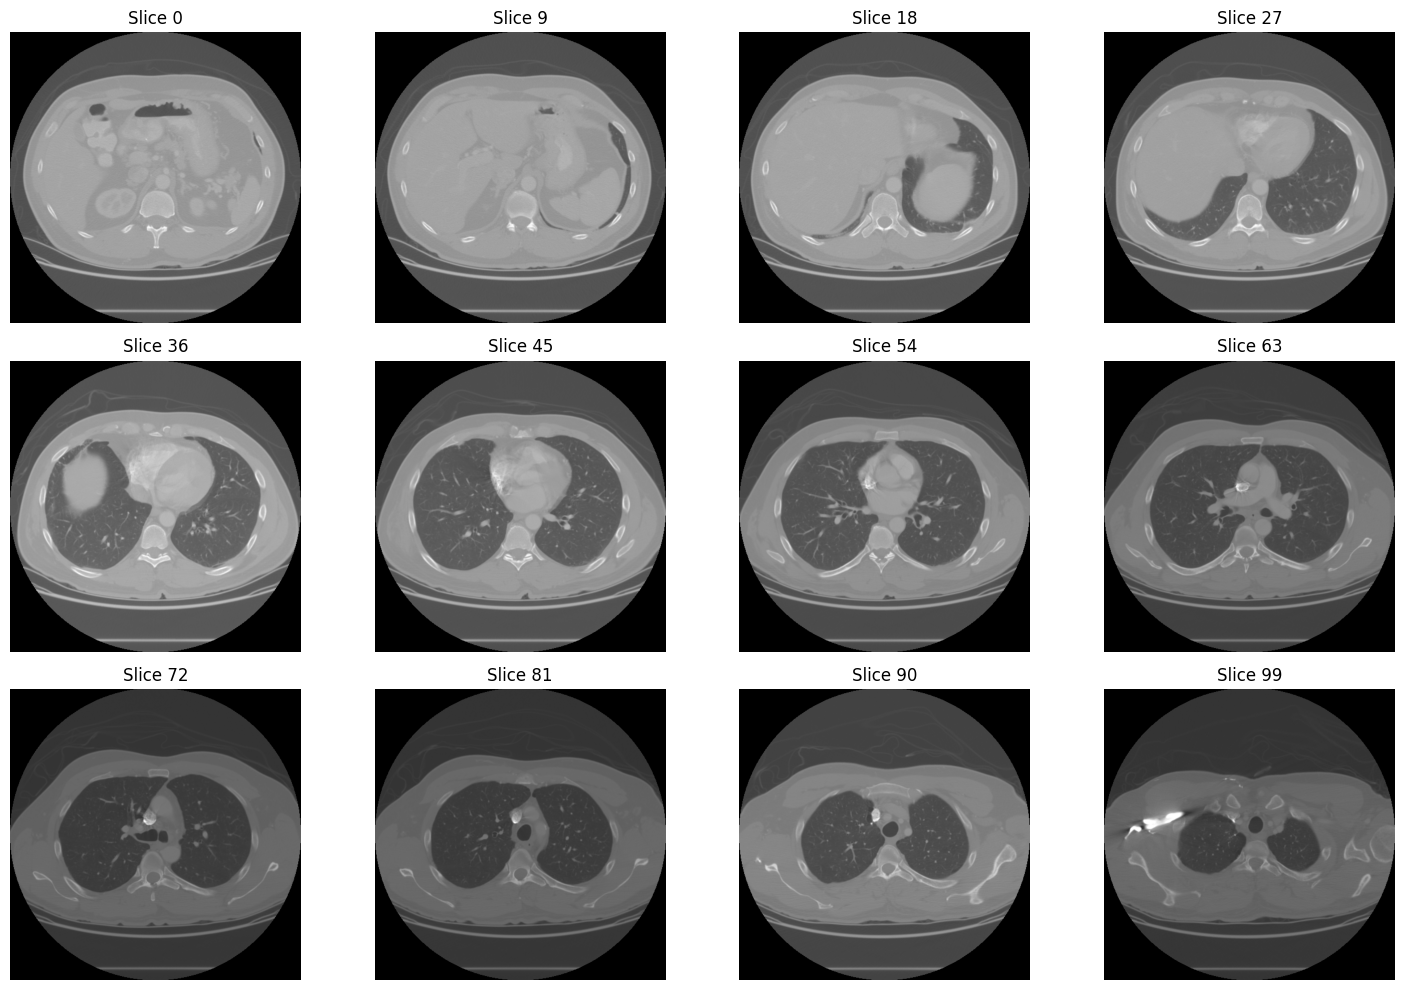

In [ ]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# Chemin vers le fichier MHD
mhd_path = "/content/drive/MyDrive/luna16_data/subset0_filtered_40/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd"

# Lire l'image
itk_image = sitk.ReadImage(mhd_path)

# Convertir en NumPy array
scan_array = sitk.GetArrayFromImage(itk_image)  # (slices, height, width)

# Infos utiles
origin = itk_image.GetOrigin()        # Origine dans l'espace
spacing = itk_image.GetSpacing()      # Espacement entre les voxels

print(f"Shape (Z, Y, X): {scan_array.shape}")
print(f"Origin: {origin}")
print(f"Spacing: {spacing}")

# Afficher quelques slices
num_slices_to_show = 12
total_slices = scan_array.shape[0]
step = total_slices // num_slices_to_show

plt.figure(figsize=(15, 10))
for i in range(num_slices_to_show):
    slice_idx = i * step
    plt.subplot(3, 4, i + 1)
    plt.imshow(scan_array[slice_idx], cmap='gray')
    plt.title(f"Slice {slice_idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd
from tqdm import tqdm

# === Dossiers ===
input_dir = "/content/drive/MyDrive/luna16_data/subset0_filtered_40"
output_dir = "/content/drive/MyDrive/luna16_data/slices_2d_npy"
os.makedirs(output_dir, exist_ok=True)

# === Fichier pour stocker les métadonnées ===
metadata = []

# === Parcours des fichiers .mhd ===
for filename in tqdm(os.listdir(input_dir)):
    if filename.endswith(".mhd"):
        filepath = os.path.join(input_dir, filename)
        scan = sitk.ReadImage(filepath)
        scan_array = sitk.GetArrayFromImage(scan)  # [Z, Y, X]
        spacing = scan.GetSpacing()  # (x, y, z)
        origin = scan.GetOrigin()
        direction = scan.GetDirection()

        # Convertir les slices une par une
        for slice_idx in range(scan_array.shape[0]):
            slice_2d = scan_array[slice_idx, :, :]
            slice_filename = f"{filename.replace('.mhd', '')}_slice{slice_idx:03}.npy"
            slice_path = os.path.join(output_dir, slice_filename)
            np.save(slice_path, slice_2d)

            # Sauvegarder les métadonnées
            metadata.append({
                "slice_id": slice_filename,
                "scan_id": filename,
                "slice_index": slice_idx,
                "spacing_x": spacing[0],
                "spacing_y": spacing[1],
                "spacing_z": spacing[2],
                "origin_x": origin[0],
                "origin_y": origin[1],
                "origin_z": origin[2],
                "direction": direction
            })

# === Sauvegarde des métadonnées dans un CSV ===
df_meta = pd.DataFrame(metadata)
df_meta.to_csv("/content/drive/MyDrive/luna16_data/slices_metadata.csv", index=False)

print("✅ Conversion 2D terminée : slices enregistrées + métadonnées.")

100%|██████████| 80/80 [03:24<00:00,  2.56s/it]


✅ Conversion 2D terminée : slices enregistrées + métadonnées.


In [ ]:
import os

folder = '/content/drive/MyDrive/luna16_data/slices_2d_npy'
npy_files = [f for f in os.listdir(folder) if f.endswith('.npy')]

print(f"🧾 Total de fichiers .npy trouvés dans slices_2d_npy : {len(npy_files)}")


🧾 Total de fichiers .npy trouvés dans slices_2d_npy : 11125


🧼 Étape : Nettoyage des intensités
Dans les images médicales (en particulier les CT scans), chaque pixel représente une valeur en Hounsfield Units (HU). Ces valeurs peuvent aller de -1000 (air) à +3000+ (os dense), mais la majorité des tissus pulmonaires se trouvent dans une plage plus restreinte.

📉 Objectif :
Supprimer les valeurs extrêmes, souvent dues à du bruit ou hors du champ d’intérêt.

Clipping (tronquage) : garder uniquement les valeurs dans l’intervalle :
-1200 HU ≤ pixel ≤ +600 HU
Cela permet de réduire la variance inutile et de concentrer le modèle sur ce qui est pertinent.



In [ ]:
import os
import numpy as np
from tqdm import tqdm

# Chemins d'entrée et de sortie
input_folder = '/content/drive/MyDrive/luna16_data/slices_2d_npy'
output_folder = '/content/luna_temp/slices_2d_cleaned'

# Créer le dossier de sortie s'il n'existe pas
os.makedirs(output_folder, exist_ok=True)

# Seuils de clipping HU
HU_MIN = -1200
HU_MAX = 600

# Lister les fichiers .npy
npy_files = [f for f in os.listdir(input_folder) if f.endswith('.npy')]

print("🧼 Nettoyage des slices en cours...")

for filename in tqdm(npy_files):
    # Charger la slice
    filepath = os.path.join(input_folder, filename)
    slice_array = np.load(filepath)

    # Appliquer le clipping HU
    slice_clipped = np.clip(slice_array, HU_MIN, HU_MAX)

    # Sauvegarder dans le dossier de sortie
    output_path = os.path.join(output_folder, filename)
    np.save(output_path, slice_clipped)

print(f"\n✅ Nettoyage terminé : {len(npy_files)} slices nettoyées et sauvegardées dans '{output_folder}'")


🧼 Nettoyage des slices en cours...


100%|██████████| 11125/11125 [07:48<00:00, 23.72it/s] 


✅ Nettoyage terminé : 11125 slices nettoyées et sauvegardées dans '/content/luna_temp/slices_2d_cleaned'


In [ ]:
import os
import numpy as np
from tqdm import tqdm

# Chemins d'entrée/sortie
input_folder = '/content/luna_temp/slices_2d_cleaned'
output_folder = '/content/luna_temp/slices_2d_normalized'

os.makedirs(output_folder, exist_ok=True)

# Plage utilisée pour la normalisation (doit correspondre à celle utilisée au clipping)
HU_MIN = -1200
HU_MAX = 600

print("🌈 Normalisation des slices en cours...")

for filename in tqdm(os.listdir(input_folder)):
    if filename.endswith('.npy'):
        # Charger la slice nettoyée
        slice_array = np.load(os.path.join(input_folder, filename))

        # Normaliser les valeurs entre 0 et 1
        normalized_slice = (slice_array - HU_MIN) / (HU_MAX - HU_MIN)
        normalized_slice = np.clip(normalized_slice, 0, 1)  # Sécurité

        # Sauvegarde
        np.save(os.path.join(output_folder, filename), normalized_slice)

print(f"\n✅ Normalisation terminée : toutes les slices sont dans '{output_folder}'")


🌈 Normalisation des slices en cours...


100%|██████████| 11125/11125 [04:37<00:00, 40.05it/s]


✅ Normalisation terminée : toutes les slices sont dans '/content/luna_temp/slices_2d_normalized'


In [ ]:
import shutil

folder_to_delete = "/content/luna_temp/slices_2d_cleaned"

# Supprimer le dossier s'il existe
if os.path.exists(folder_to_delete):
    shutil.rmtree(folder_to_delete)
    print(f"🗑️ Dossier supprimé : {folder_to_delete}")
else:
    print(f"❌ Dossier non trouvé : {folder_to_delete}")


🗑️ Dossier supprimé : /content/luna_temp/slices_2d_cleaned


In [ ]:
import os
import numpy as np
import cv2
from skimage import measure, morphology
from scipy.ndimage import binary_fill_holes
from tqdm import tqdm

# Dossier d'entrée et de sortie
input_folder = "/content/drive/MyDrive/luna16_data/slices_2d_npy"
output_folder = "/content/luna_temp/slices_2d_segmented"
os.makedirs(output_folder, exist_ok=True)

def segment_lungs_2d(image):
    # Étape 1 : Seuil à -600 HU
    binary = np.array(image > -600, dtype=np.uint8)

    # Étape 2 : Nettoyage morphologique
    binary = cv2.erode(binary, np.ones((3, 3), np.uint8), iterations=1)
    binary = cv2.dilate(binary, np.ones((5, 5), np.uint8), iterations=2)

    # Étape 3 : Étiquetage des régions connexes
    labels = measure.label(binary)
    props = measure.regionprops(labels)

    # Garder les 2 plus grandes régions
    if len(props) > 2:
        areas = [p.area for p in props]
        largest_labels = np.argsort(areas)[-2:]
        mask = np.isin(labels, [props[i].label for i in largest_labels])
    else:
        mask = labels > 0

    # Étape 4 : Remplir les trous (utilise scipy)
    mask = morphology.binary_closing(mask, morphology.disk(3))
    mask = binary_fill_holes(mask)  # ✅ Utilisation correcte ici

    # Appliquer le masque sur l'image
    segmented = np.where(mask, image, -1000)
    return segmented

# Application sur toutes les slices
files = sorted([f for f in os.listdir(input_folder) if f.endswith(".npy")])
print(f"Total slices à segmenter : {len(files)}")

for f in tqdm(files):
    img = np.load(os.path.join(input_folder, f))
    segmented = segment_lungs_2d(img)
    np.save(os.path.join(output_folder, f), segmented)

print("✅ Segmentation terminée. Slices sauvegardées dans :", output_folder)


Total slices à segmenter : 11125


100%|██████████| 11125/11125 [31:42<00:00,  5.85it/s]

✅ Segmentation terminée. Slices sauvegardées dans : /content/luna_temp/slices_2d_segmented


🎯 Rôle du fichier slices_metadata.csv
Ce fichier .csv va contenir les métadonnées associées à chaque slice 2D, pour qu’on puisse :

🧠 1. Suivre les infos du scan original
Chaque slice 2D vient d’un volume 3D .mhd. Ce fichier contient :

Les dimensions réelles du voxel : Spacing = (x, y, z) → souvent comme (0.7, 0.7, 2.0)

L’index de la slice dans le volume

L’origine dans l’espace (optionnel)

Ces données sont perdues quand on extrait les slices, donc on les stocke ici.

🛠 2. Normalisation spatiale (plus tard)
Quand on veut mettre toutes les images à une échelle uniforme (ex: 1mm × 1mm), on aura besoin du spacing_x et spacing_y pour chaque slice → ce fichier nous permettra de redimensionner les images de manière cohérente.

📊 3. Suivi & organisation
Il contient pour chaque image :

Le nom de fichier .npy

Le patient ou scan source

Le spacing (x, y, z)

Donc c’est une base de données légère pour tout ce qu’on va faire ensuite : entraînement, visualisation, etc.

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

input_folder = "/content/luna_temp/slices_2d_segmented"
metadata_output = "/content/drive/MyDrive/luna16_data/slices_metadata_vF.csv"

data = []

files = sorted([f for f in os.listdir(input_folder) if f.endswith(".npy")])
print("Total slices à enregistrer dans le nouveau CSV :", len(files))

for f in tqdm(files):
    arr = np.load(os.path.join(input_folder, f))
    spacing_z = 1.0  # Si inconnu, on peut fixer par défaut à 1mm pour 2D
    spacing_y = arr.shape[0]
    spacing_x = arr.shape[1]

    data.append({
        "filename": f,
        "shape": arr.shape,
        "spacing_z": spacing_z,
        "spacing_y": spacing_y,
        "spacing_x": spacing_x
    })

df = pd.DataFrame(data)
df.to_csv(metadata_output, index=False)
print("✅ Nouveau fichier metadata sauvegardé :", metadata_output)


Total slices à enregistrer dans le nouveau CSV : 11125


100%|██████████| 11125/11125 [00:33<00:00, 328.40it/s]


✅ Nouveau fichier metadata sauvegardé : /content/drive/MyDrive/luna16_data/slices_metadata_vF.csv


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/luna16_data/slices_metadata.csv")
print("Nombres de slices enregistrées dans le CSV :", len(df))


Nombres de slices enregistrées dans le CSV : 11125


**🧩 Étape 1 – Filtrage et sauvegarde des candidats compatibles**
On filtre uniquement les candidats appartenant aux 40 scans .mhd, puis on enregistre ce sous-ensemble dans un nouveau fichier .csv.

In [ ]:
import pandas as pd
import os

# Chemins
candidates_path = "/content/drive/MyDrive/luna16_data/candidates.csv"
mhd_folder = "/content/drive/MyDrive/luna16_data/subset0_filtered_40"
filtered_candidates_path = "/content/drive/MyDrive/luna16_data/candidates_filtered_40.csv"

# Obtenir la liste des seriesuid disponibles
valid_seriesuids = [f.replace(".mhd", "") for f in os.listdir(mhd_folder) if f.endswith(".mhd")]

# Charger les candidats
df = pd.read_csv(candidates_path)
df.columns = ["seriesuid", "coordX", "coordY", "coordZ", "class"]

# Filtrer uniquement ceux correspondant aux 40 scans
filtered_df = df[df["seriesuid"].isin(valid_seriesuids)].reset_index(drop=True)

# Sauvegarder dans un nouveau CSV
filtered_df.to_csv(filtered_candidates_path, index=False)
print(f"✅ Candidats filtrés sauvegardés dans : {filtered_candidates_path}")
print(f"📊 Nombre total de candidats compatibles avec les 40 scans : {len(filtered_df)}")


✅ Candidats filtrés sauvegardés dans : /content/drive/MyDrive/luna16_data/candidates_filtered_40.csv
📊 Nombre total de candidats compatibles avec les 40 scans : 37540


**📦 Étape 2 – Extraction des patches 2D équilibrés (à partir du fichier filtré)**

In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
from tqdm import tqdm

# === Chemins ===
filtered_candidates_path = "/content/drive/MyDrive/luna16_data/candidates_filtered_40.csv"
output_folder = "/content/drive/MyDrive/luna16_data_backup/patches_all_unbalanced"
mhd_folder = "/content/drive/MyDrive/luna16_data/subset0_filtered_40"
os.makedirs(output_folder, exist_ok=True)

# === Paramètres ===
PATCH_SIZE = 64
HALF_SIZE = PATCH_SIZE // 2

# === Étape 1 : Chargement des scans ===
print("🔄 Chargement des scans .mhd...")
scans = {}
for fname in tqdm(os.listdir(mhd_folder)):
    if fname.endswith(".mhd"):
        uid = fname.replace(".mhd", "")
        path = os.path.join(mhd_folder, fname)
        img = sitk.ReadImage(path)
        arr = sitk.GetArrayFromImage(img)
        origin = np.array(img.GetOrigin())
        spacing = np.array(img.GetSpacing())
        scans[uid] = (arr, origin, spacing)
print(f"✅ {len(scans)} scans chargés.")

# === Étape 2 : Chargement de tous les candidats compatibles ===
df = pd.read_csv(filtered_candidates_path)
df["class"] = df["class"].astype(int)

n_nodules = 0
n_non_nodules = 0
total = 0

# === Étape 3 : Extraction de tous les patches valides ===
for _, row in tqdm(df.iterrows(), total=len(df)):
    uid = row["seriesuid"]
    if uid not in scans:
        continue

    scan, origin, spacing = scans[uid]
    world = np.array([row["coordX"], row["coordY"], row["coordZ"]])
    voxel = np.round((world - origin) / spacing).astype(int)
    x, y, z = voxel

    if z < 0 or z >= scan.shape[0]:
        continue

    slice_ = scan[z]
    if y - HALF_SIZE < 0 or y + HALF_SIZE > slice_.shape[0]:
        continue
    if x - HALF_SIZE < 0 or x + HALF_SIZE > slice_.shape[1]:
        continue

    patch = slice_[y - HALF_SIZE:y + HALF_SIZE, x - HALF_SIZE:x + HALF_SIZE]
    if patch.shape != (PATCH_SIZE, PATCH_SIZE):
        continue

    label = "nodule" if row["class"] == 1 else "non_nodule"
    filename = f"{uid}_z{z}_{label}.npy"
    np.save(os.path.join(output_folder, filename), patch)

    if row["class"] == 1:
        n_nodules += 1
    else:
        n_non_nodules += 1
    total += 1

print(f"✅ Extraction terminée.")
print(f"📦 Nombre total de patches extraits : {total}")
print(f"🧩 Vrais nodules : {n_nodules}")
print(f"🧩 Faux nodules : {n_non_nodules}")


🔄 Chargement des scans .mhd...


100%|██████████| 80/80 [00:31<00:00,  2.50it/s]


✅ 40 scans chargés.


100%|██████████| 37540/37540 [06:21<00:00, 98.32it/s] 

✅ Extraction terminée.
📦 Nombre total de patches extraits : 37492
🧩 Vrais nodules : 79
🧩 Faux nodules : 37413


In [ ]:
import pandas as pd
import os

# Charger les fichiers
annotations_path = "/content/drive/MyDrive/luna16_data/annotations.csv"
candidates_path = "/content/drive/MyDrive/luna16_data/candidates.csv"

annotations = pd.read_csv(annotations_path)
candidates = pd.read_csv(candidates_path)

# Matching candidats ↔ annotations
matching_candidates = []

for _, annotation in annotations.iterrows():
    seriesuid = annotation['seriesuid']
    matches = candidates[candidates['seriesuid'] == seriesuid]

    if not matches.empty:
        filtered = matches[
            (abs(matches['coordX'] - annotation['coordX']) <= 10) &
            (abs(matches['coordY'] - annotation['coordY']) <= 10) &
            (abs(matches['coordZ'] - annotation['coordZ']) <= 10)
        ]

        if not filtered.empty:
            matching_candidates.append(filtered)

# Fusion des résultats
matching_df = pd.concat(matching_candidates, ignore_index=True)
matching_path = "/content/drive/MyDrive/luna16_data/matching_candidates.csv"
matching_df.to_csv(matching_path, index=False)
print(f"✔ Matching terminé : {len(matching_df)} candidats sauvegardés dans {matching_path}")

✔ Matching terminé : 2636 candidats sauvegardés dans /content/drive/MyDrive/luna16_data/matching_candidates.csv


In [ ]:
import os
import pandas as pd

# Paths
annotations_path = "/content/drive/MyDrive/luna16_data/annotations.csv"
subset0_path = "/content/luna16/subset0/subset0"
subset0_40_path = "/content/drive/MyDrive/luna16_data/subset0_filtered_40"

# Charger annotations.csv
df_ann = pd.read_csv(annotations_path)
print(f"✅ Annotations chargées : {len(df_ann)}")

# Lister les seriesuid des scans présents dans subset0 complet
subset0_uids = sorted([
    f.replace(".mhd", "") for f in os.listdir(subset0_path) if f.endswith(".mhd")
])
print(f"📂 Nombre de scans .mhd dans subset0 : {len(subset0_uids)}")


✅ Annotations chargées : 1186
📂 Nombre de scans .mhd dans subset0 : 89


In [ ]:
# UIDs déjà extraits dans subset0_filtered_40
subset0_40_uids = sorted([
    f.replace(".mhd", "") for f in os.listdir(subset0_40_path) if f.endswith(".mhd")
])
print(f"📦 Scans déjà extraits dans subset0_filtered_40 : {len(subset0_40_uids)}")


📦 Scans déjà extraits dans subset0_filtered_40 : 40


In [ ]:
# Garder uniquement les nodules qui ne sont pas encore extraits
df_new_nodules = df_ann_subset0[~df_ann_subset0["seriesuid"].isin(subset0_40_uids)].copy()
print(f"🆕 Nouveaux vrais nodules (non extraits) : {len(df_new_nodules)}")


🆕 Nouveaux vrais nodules (non extraits) : 45


In [ ]:
import os

# Répertoire complet et répertoire des scans déjà utilisés
all_scans_dir = "/content/luna16/subset0/subset0"
used_scans_dir = "/content/drive/MyDrive/luna16_data/subset0_filtered_40"

# Identifiants des scans
all_scan_uids = {f.replace(".mhd", "") for f in os.listdir(all_scans_dir) if f.endswith(".mhd")}
used_scan_uids = {f.replace(".mhd", "") for f in os.listdir(used_scans_dir) if f.endswith(".mhd")}

# Nouveaux scans
new_scan_uids = all_scan_uids - used_scan_uids
print(f"🆕 Nouveaux scans détectés : {len(new_scan_uids)}")


🆕 Nouveaux scans détectés : 49


In [ ]:
import pandas as pd

# Chargement du fichier annotations.csv
annotations_path = "/content/drive/MyDrive/luna16_data/annotations.csv"
df_ann = pd.read_csv(annotations_path)

# Filtrage
df_new_nodules = df_ann[df_ann["seriesuid"].isin(new_scan_uids)].copy()
print(f"📊 Nombre de vrais nodules dans les nouveaux scans : {len(df_new_nodules)}")


📊 Nombre de vrais nodules dans les nouveaux scans : 45


In [ ]:
import os
import shutil
import pandas as pd

# Dossiers
subset0_path = "/content/luna16/subset0/subset0"
subset0_filtered_40_path = "/content/drive/MyDrive/luna16_data/subset0_filtered_40"
nouveaux_scans_path = "/content/luna16/nouveaux_scans_positifs"
os.makedirs(nouveaux_scans_path, exist_ok=True)

# Chargement des noms déjà extraits
extraits = {f.replace(".mhd", "") for f in os.listdir(subset0_filtered_40_path) if f.endswith(".mhd")}

# Chargement des annotations
annotations_path = "/content/drive/MyDrive/luna16_data/annotations.csv"
df_annots = pd.read_csv(annotations_path)
uids_tous = {f.replace(".mhd", "") for f in os.listdir(subset0_path) if f.endswith(".mhd")}
uids_positifs = set(df_annots["seriesuid"].unique())
uids_nouveaux = uids_positifs.intersection(uids_tous).difference(extraits)

print(f"📦 Nombre de fichiers à copier : {len(uids_nouveaux)}")

# Copier les .mhd et .raw
for uid in uids_nouveaux:
    mhd_src = os.path.join(subset0_path, f"{uid}.mhd")
    raw_src = os.path.join(subset0_path, f"{uid}.raw")

    mhd_dst = os.path.join(nouveaux_scans_path, f"{uid}.mhd")
    raw_dst = os.path.join(nouveaux_scans_path, f"{uid}.raw")

    if os.path.exists(mhd_src) and os.path.exists(raw_src):
        shutil.copy(mhd_src, mhd_dst)
        shutil.copy(raw_src, raw_dst)

print(f"✅ Fichiers copiés dans : {nouveaux_scans_path}")


📦 Nombre de fichiers à copier : 27
✅ Fichiers copiés dans : /content/luna16/nouveaux_scans_positifs


In [ ]:
import os
import SimpleITK as sitk

# Chemin vers le dossier contenant les fichiers .mhd
subset_path = "/content/luna16/nouveaux_scans_positifs"

# Lister les fichiers .mhd
mhd_files = [f for f in os.listdir(subset_path) if f.endswith(".mhd")]

print(f"📂 Total des scans trouvés : {len(mhd_files)}\n")

# Initialiser le compteur de slices
total_slices = 0

# Parcourir chaque fichier et additionner le nombre de slices (profondeur Z)
for file in mhd_files:
    file_path = os.path.join(subset_path, file)
    image = sitk.ReadImage(file_path)
    size = image.GetSize()  # (X, Y, Z)
    slices = size[2]
    total_slices += slices
    print(f"{file}: {slices} slices")

# Afficher le total
print("\n🧮 Total de tous les slices dans les 40 scans :", total_slices)


📂 Total des scans trouvés : 27

1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.mhd: 140 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281.mhd: 516 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896.mhd: 229 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273.mhd: 147 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.mhd: 200 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145.mhd: 129 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596.mhd: 474 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843.mhd: 141 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345.mhd: 392 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.640729228179368154416184318668.mhd: 483 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488.mhd: 139 slices
1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321.mhd: 157 sli

Shape (Z, Y, X): (474, 512, 512)
Origin: (-167.800003, -160.0, -251.514999)
Spacing: (0.625, 0.625, 0.625)


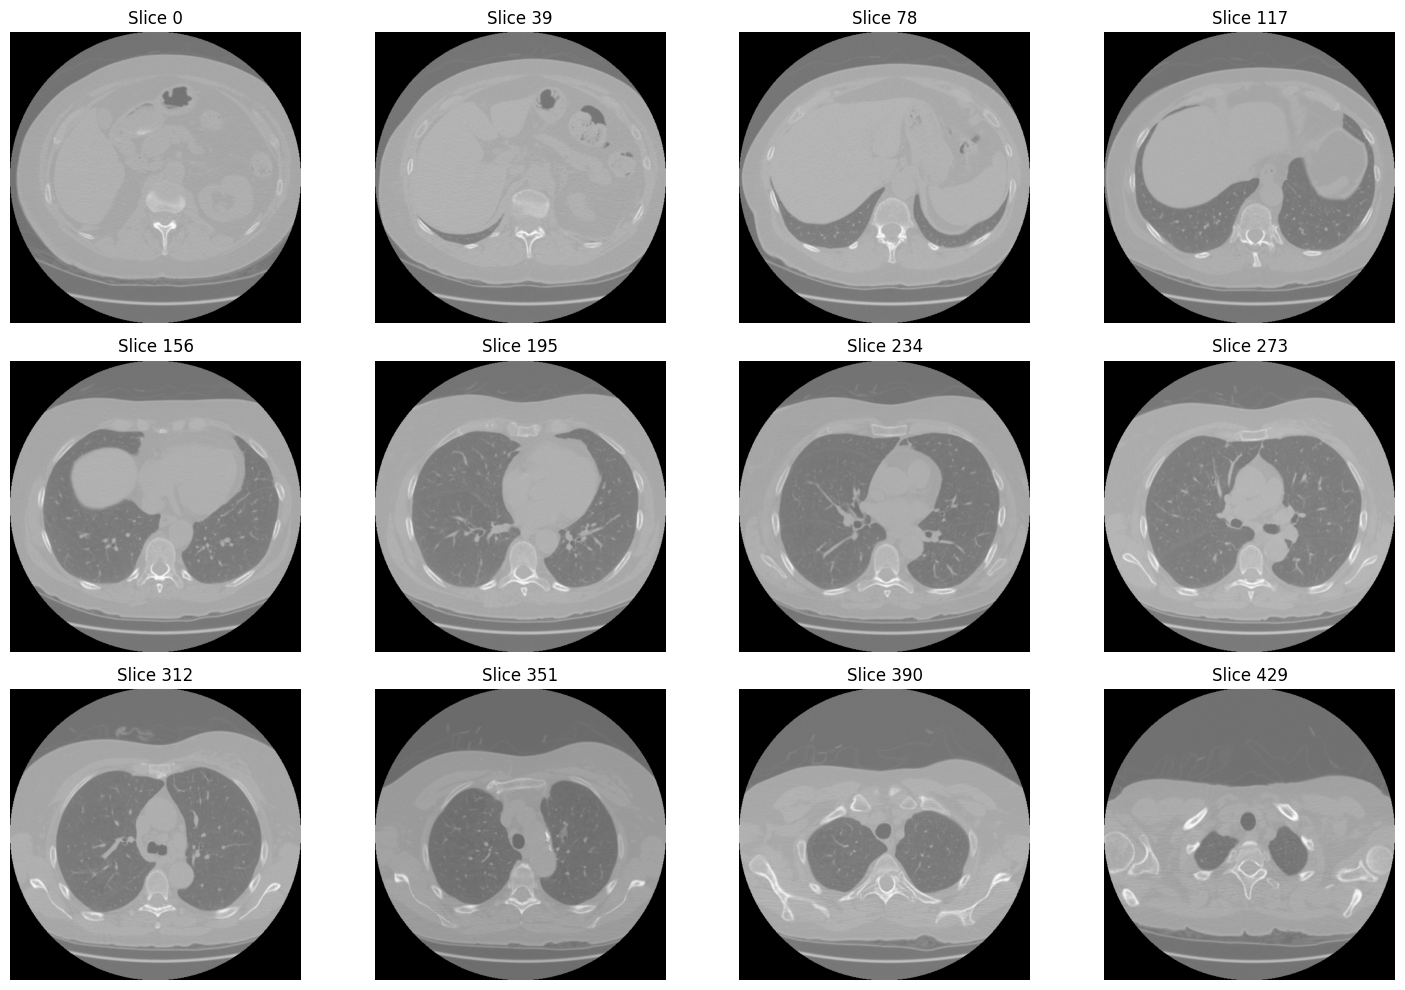

In [ ]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# Chemin vers le fichier MHD
mhd_path = "/content/luna16/nouveaux_scans_positifs/1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596.mhd"

# Lire l'image
itk_image = sitk.ReadImage(mhd_path)

# Convertir en NumPy array
scan_array = sitk.GetArrayFromImage(itk_image)  # (slices, height, width)

# Infos utiles
origin = itk_image.GetOrigin()        # Origine dans l'espace
spacing = itk_image.GetSpacing()      # Espacement entre les voxels

print(f"Shape (Z, Y, X): {scan_array.shape}")
print(f"Origin: {origin}")
print(f"Spacing: {spacing}")

# Afficher quelques slices
num_slices_to_show = 12
total_slices = scan_array.shape[0]
step = total_slices // num_slices_to_show

plt.figure(figsize=(15, 10))
for i in range(num_slices_to_show):
    slice_idx = i * step
    plt.subplot(3, 4, i + 1)
    plt.imshow(scan_array[slice_idx], cmap='gray')
    plt.title(f"Slice {slice_idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd
from tqdm import tqdm

# === Dossiers ===
input_dir = "/content/luna16/nouveaux_scans_positifs"
output_dir = "/content/luna16/nouveaux_scans_positifs/slices_2d_npy"
os.makedirs(output_dir, exist_ok=True)

# === Fichier pour stocker les métadonnées ===
metadata = []

# === Parcours des fichiers .mhd ===
for filename in tqdm(os.listdir(input_dir)):
    if filename.endswith(".mhd"):
        filepath = os.path.join(input_dir, filename)
        scan = sitk.ReadImage(filepath)
        scan_array = sitk.GetArrayFromImage(scan)  # [Z, Y, X]
        spacing = scan.GetSpacing()  # (x, y, z)
        origin = scan.GetOrigin()
        direction = scan.GetDirection()

        # Convertir les slices une par une
        for slice_idx in range(scan_array.shape[0]):
            slice_2d = scan_array[slice_idx, :, :]
            slice_filename = f"{filename.replace('.mhd', '')}_slice{slice_idx:03}.npy"
            slice_path = os.path.join(output_dir, slice_filename)
            np.save(slice_path, slice_2d)

            # Sauvegarder les métadonnées
            metadata.append({
                "slice_id": slice_filename,
                "scan_id": filename,
                "slice_index": slice_idx,
                "spacing_x": spacing[0],
                "spacing_y": spacing[1],
                "spacing_z": spacing[2],
                "origin_x": origin[0],
                "origin_y": origin[1],
                "origin_z": origin[2],
                "direction": direction
            })

# === Sauvegarde des métadonnées dans un CSV ===
df_meta = pd.DataFrame(metadata)
df_meta.to_csv("/content/luna16/nouveaux_scans_positifs/slices_metadata.csv", index=False)

print("✅ Conversion 2D terminée : slices enregistrées + métadonnées.")

100%|██████████| 55/55 [01:56<00:00,  2.12s/it]


✅ Conversion 2D terminée : slices enregistrées + métadonnées.


In [ ]:
import os

folder = '/content/luna16/nouveaux_scans_positifs/slices_2d_npy'
npy_files = [f for f in os.listdir(folder) if f.endswith('.npy')]

print(f"🧾 Total de fichiers .npy trouvés dans slices_2d_npy : {len(npy_files)}")


🧾 Total de fichiers .npy trouvés dans slices_2d_npy : 7294


In [ ]:
import os
import numpy as np
from tqdm import tqdm

# Chemins d'entrée et de sortie
input_folder = '/content/luna16/nouveaux_scans_positifs/slices_2d_npy'
output_folder = '/content/luna16/slices_2d_cleaned'

# Créer le dossier de sortie s'il n'existe pas
os.makedirs(output_folder, exist_ok=True)

# Seuils de clipping HU
HU_MIN = -1200
HU_MAX = 600

# Lister les fichiers .npy
npy_files = [f for f in os.listdir(input_folder) if f.endswith('.npy')]

print("🧼 Nettoyage des slices en cours...")

for filename in tqdm(npy_files):
    # Charger la slice
    filepath = os.path.join(input_folder, filename)
    slice_array = np.load(filepath)

    # Appliquer le clipping HU
    slice_clipped = np.clip(slice_array, HU_MIN, HU_MAX)

    # Sauvegarder dans le dossier de sortie
    output_path = os.path.join(output_folder, filename)
    np.save(output_path, slice_clipped)

print(f"\n✅ Nettoyage terminé : {len(npy_files)} slices nettoyées et sauvegardées dans '{output_folder}'")


🧼 Nettoyage des slices en cours...


100%|██████████| 7294/7294 [01:36<00:00, 75.60it/s] 


✅ Nettoyage terminé : 7294 slices nettoyées et sauvegardées dans '/content/luna16/slices_2d_cleaned'


In [ ]:
import os
import numpy as np
from tqdm import tqdm

# Chemins d'entrée/sortie
input_folder = '/content/luna16/slices_2d_cleaned'
output_folder = '/content/luna16/slices_2d_normalized'

os.makedirs(output_folder, exist_ok=True)

# Plage utilisée pour la normalisation (doit correspondre à celle utilisée au clipping)
HU_MIN = -1200
HU_MAX = 600

print("🌈 Normalisation des slices en cours...")

for filename in tqdm(os.listdir(input_folder)):
    if filename.endswith('.npy'):
        # Charger la slice nettoyée
        slice_array = np.load(os.path.join(input_folder, filename))

        # Normaliser les valeurs entre 0 et 1
        normalized_slice = (slice_array - HU_MIN) / (HU_MAX - HU_MIN)
        normalized_slice = np.clip(normalized_slice, 0, 1)  # Sécurité

        # Sauvegarde
        np.save(os.path.join(output_folder, filename), normalized_slice)

print(f"\n✅ Normalisation terminée : toutes les slices sont dans '{output_folder}'")


🌈 Normalisation des slices en cours...


100%|██████████| 7294/7294 [06:07<00:00, 19.83it/s]


✅ Normalisation terminée : toutes les slices sont dans '/content/luna16/slices_2d_normalized'


In [ ]:
import shutil

folder_to_delete = "/content/luna16/slices_2d_cleaned"

# Supprimer le dossier s'il existe
if os.path.exists(folder_to_delete):
    shutil.rmtree(folder_to_delete)
    print(f"🗑️ Dossier supprimé : {folder_to_delete}")
else:
    print(f"❌ Dossier non trouvé : {folder_to_delete}")


🗑️ Dossier supprimé : /content/luna16/slices_2d_cleaned


In [ ]:
import os
import numpy as np
import cv2
from skimage import measure, morphology
from scipy.ndimage import binary_fill_holes
from tqdm import tqdm

# Dossier d'entrée et de sortie
input_folder = "/content/luna16/nouveaux_scans_positifs/slices_2d_npy"
output_folder = "'/content/luna16/slices_2d_segmented"
os.makedirs(output_folder, exist_ok=True)

def segment_lungs_2d(image):
    # Étape 1 : Seuil à -600 HU
    binary = np.array(image > -600, dtype=np.uint8)

    # Étape 2 : Nettoyage morphologique
    binary = cv2.erode(binary, np.ones((3, 3), np.uint8), iterations=1)
    binary = cv2.dilate(binary, np.ones((5, 5), np.uint8), iterations=2)

    # Étape 3 : Étiquetage des régions connexes
    labels = measure.label(binary)
    props = measure.regionprops(labels)

    # Garder les 2 plus grandes régions
    if len(props) > 2:
        areas = [p.area for p in props]
        largest_labels = np.argsort(areas)[-2:]
        mask = np.isin(labels, [props[i].label for i in largest_labels])
    else:
        mask = labels > 0

    # Étape 4 : Remplir les trous (utilise scipy)
    mask = morphology.binary_closing(mask, morphology.disk(3))
    mask = binary_fill_holes(mask)  # ✅ Utilisation correcte ici

    # Appliquer le masque sur l'image
    segmented = np.where(mask, image, -1000)
    return segmented

# Application sur toutes les slices
files = sorted([f for f in os.listdir(input_folder) if f.endswith(".npy")])
print(f"Total slices à segmenter : {len(files)}")

for f in tqdm(files):
    img = np.load(os.path.join(input_folder, f))
    segmented = segment_lungs_2d(img)
    np.save(os.path.join(output_folder, f), segmented)

print("✅ Segmentation terminée. Slices sauvegardées dans :", output_folder)


Total slices à segmenter : 7294


100%|██████████| 7294/7294 [06:01<00:00, 20.19it/s]

✅ Segmentation terminée. Slices sauvegardées dans : '/content/luna16/slices_2d_segmented


In [ ]:
import shutil
import os

# Corriger le nom du dossier mal formé
wrong_path = "'/content/luna16/slices_2d_segmented"  # avec guillemet mal placé
correct_path = "/content/luna16/slices_2d_segmented"

# Si le dossier mal formé existe, on le renomme
if os.path.exists(wrong_path):
    os.rename(wrong_path, correct_path)
    print(f"📦 Dossier renommé en : {correct_path}")
else:
    print("⚠️ Aucun dossier mal nommé trouvé. Vérifie le chemin.")

# Maintenant tu as : /content/luna16/slices_2d_segmented avec toutes les slices segmentées ✅


📦 Dossier renommé en : /content/luna16/slices_2d_segmented


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

input_folder = "/content/luna16/slices_2d_segmented"
metadata_output = "/content/drive/MyDrive/luna16_data/slices_metadata_vF213.csv"

data = []

files = sorted([f for f in os.listdir(input_folder) if f.endswith(".npy")])
print("Total slices à enregistrer dans le nouveau CSV :", len(files))

for f in tqdm(files):
    arr = np.load(os.path.join(input_folder, f))
    spacing_z = 1.0  # Si inconnu, on peut fixer par défaut à 1mm pour 2D
    spacing_y = arr.shape[0]
    spacing_x = arr.shape[1]

    data.append({
        "filename": f,
        "shape": arr.shape,
        "spacing_z": spacing_z,
        "spacing_y": spacing_y,
        "spacing_x": spacing_x
    })

df = pd.DataFrame(data)
df.to_csv(metadata_output, index=False)
print("✅ Nouveau fichier metadata sauvegardé :", metadata_output)


Total slices à enregistrer dans le nouveau CSV : 7294


100%|██████████| 7294/7294 [00:22<00:00, 317.31it/s]


✅ Nouveau fichier metadata sauvegardé : /content/drive/MyDrive/luna16_data/slices_metadata_vF213.csv


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/luna16_data/slices_metadata_vF213.csv")
print("Nombres de slices enregistrées dans le CSV :", len(df))


Nombres de slices enregistrées dans le CSV : 7294


In [ ]:
import shutil
import os

# Corriger le nom du dossier mal formé
wrong_path = "/content/luna16/nouveaux_scans_positifs/slices_2d_npy"
correct_path = "/content/luna16/slices_2d_npy"

# Si le dossier mal formé existe, on le renomme
if os.path.exists(wrong_path):
    os.rename(wrong_path, correct_path)
    print(f"📦 Dossier renommé en : {correct_path}")
else:
    print("⚠️ Aucun dossier mal nommé trouvé. Vérifie le chemin.")



📦 Dossier renommé en : /content/luna16/slices_2d_npy


In [ ]:
import os
import pandas as pd

# Chemin vers le fichier complet des candidats
candidates_all_path = "/content/drive/MyDrive/luna16_data/candidates.csv"

# Charger tous les candidats
df_all = pd.read_csv(candidates_all_path)

# Chemin vers les 27 nouveaux scans
nouveaux_scans_folder = "/content/luna16/nouveaux_scans_positifs"
uids_nouveaux = [f.replace(".mhd", "") for f in os.listdir(nouveaux_scans_folder) if f.endswith(".mhd")]

# Filtrer les candidats pour ne garder que ceux dont l'UID est dans les nouveaux scans
df_nouveaux = df_all[df_all["seriesuid"].isin(uids_nouveaux)].copy()

# Vérification
print("📄 Candidats trouvés pour les nouveaux scans :", len(df_nouveaux))

# Sauvegarde
filtered_nouveaux_path = "/content/drive/MyDrive/luna16_data/candidates_nouveaux.csv"
df_nouveaux.to_csv(filtered_nouveaux_path, index=False)
print("✅ Fichier sauvegardé :", filtered_nouveaux_path)


📄 Candidats trouvés pour les nouveaux scans : 27485
✅ Fichier sauvegardé : /content/drive/MyDrive/luna16_data/candidates_nouveaux.csv


In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
from tqdm import tqdm

# === Chemins ===
candidates_path = "/content/drive/MyDrive/luna16_data/candidates_nouveaux.csv"
scans_folder = "/content/luna16/nouveaux_scans_positifs"
output_folder = "/content/luna16/patches_nouveaux_unbalanced"
os.makedirs(output_folder, exist_ok=True)

# === Paramètres ===
PATCH_SIZE = 64
HALF_SIZE = PATCH_SIZE // 2

# === Étape 1 : Chargement des scans disponibles (27 nouveaux uniquement) ===
print("🔄 Chargement des nouveaux scans .mhd...")
scans = {}
available_uids = []

for fname in tqdm(os.listdir(scans_folder)):
    if fname.endswith(".mhd"):
        uid = fname.replace(".mhd", "")
        path = os.path.join(scans_folder, fname)
        img = sitk.ReadImage(path)
        arr = sitk.GetArrayFromImage(img)
        origin = np.array(img.GetOrigin())
        spacing = np.array(img.GetSpacing())
        scans[uid] = (arr, origin, spacing)
        available_uids.append(uid)

print(f"✅ {len(scans)} nouveaux scans chargés.")

# === Étape 2 : Filtrage des candidats ===
df = pd.read_csv(candidates_path)
df = df[df["seriesuid"].isin(available_uids)].copy()
df["class"] = df["class"].astype(int)
print(f"📄 Candidats filtrés pour les nouveaux scans : {len(df)}")

# === Étape 3 : Extraction des patches ===
n_nodules = 0
n_non_nodules = 0
total = 0

for _, row in tqdm(df.iterrows(), total=len(df)):
    uid = row["seriesuid"]
    scan, origin, spacing = scans[uid]

    world = np.array([row["coordX"], row["coordY"], row["coordZ"]])
    voxel = np.round((world - origin) / spacing).astype(int)
    x, y, z = voxel

    if z < 0 or z >= scan.shape[0]:
        continue

    slice_ = scan[z]
    if y - HALF_SIZE < 0 or y + HALF_SIZE > slice_.shape[0]:
        continue
    if x - HALF_SIZE < 0 or x + HALF_SIZE > slice_.shape[1]:
        continue

    patch = slice_[y - HALF_SIZE:y + HALF_SIZE, x - HALF_SIZE:x + HALF_SIZE]
    if patch.shape != (PATCH_SIZE, PATCH_SIZE):
        continue

    label = "nodule" if row["class"] == 1 else "non_nodule"
    filename = f"{uid}_z{z}_{label}.npy"
    np.save(os.path.join(output_folder, filename), patch)

    if row["class"] == 1:
        n_nodules += 1
    else:
        n_non_nodules += 1
    total += 1

# === Résumé ===
print("✅ Extraction terminée.")
print(f"📦 Total patches extraits : {total}")
print(f"🧩 Vrais nodules : {n_nodules}")
print(f"🧩 Faux nodules : {n_non_nodules}")
print(f"📁 Dossier : {output_folder}")


🔄 Chargement des nouveaux scans .mhd...


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


✅ 27 nouveaux scans chargés.
📄 Candidats filtrés pour les nouveaux scans : 27485


100%|██████████| 27485/27485 [00:15<00:00, 1811.18it/s]

✅ Extraction terminée.
📦 Total patches extraits : 27476
🧩 Vrais nodules : 59
🧩 Faux nodules : 27417
📁 Dossier : /content/luna16/patches_nouveaux_unbalanced


In [ ]:
import os
import shutil
from tqdm import tqdm

# === Dossiers source ===
old_patches = "/content/drive/MyDrive/luna16_data_backup/patches_all_unbalanced"
new_patches = "/content/luna16/patches_nouveaux_unbalanced"

# === Dossier de sortie fusionné ===
merged_output = "/content/luna16/patches_2d_all_unbalanced_merged"
os.makedirs(merged_output, exist_ok=True)

# === Fonction utilitaire pour copier les fichiers ===
def copy_all_files(src_folder, dst_folder):
    files = [f for f in os.listdir(src_folder) if f.endswith(".npy")]
    for f in tqdm(files, desc=f"Copie depuis {os.path.basename(src_folder)}"):
        src = os.path.join(src_folder, f)
        dst = os.path.join(dst_folder, f)
        if not os.path.exists(dst):  # pour éviter les doublons
            shutil.copy(src, dst)

# === Fusion ===
copy_all_files(old_patches, merged_output)
copy_all_files(new_patches, merged_output)

# === Résultat final ===
print("✅ Fusion terminée.")
print("📁 Dossier final :", merged_output)
print("📊 Total de fichiers fusionnés :", len(os.listdir(merged_output)))


Copie depuis patches_nouveaux_unbalanced: 100%|██████████| 5057/5057 [00:04<00:00, 1242.34it/s]

✅ Fusion terminée.
📁 Dossier final : /content/luna16/patches_2d_all_unbalanced_merged
📊 Total de fichiers fusionnés : 12966


In [ ]:
import os

folder = "/content/luna16/patches_2d_all_unbalanced_merged"

true_nodules = 0
false_nodules = 0

for f in os.listdir(folder):
    if f.endswith(".npy"):
        if "nodule" in f and "non_nodule" not in f:
            true_nodules += 1
        elif "non_nodule" in f:
            false_nodules += 1

print("✅ Comptage terminé.")
print(f"🧩 Vrais nodules     : {true_nodules}")
print(f"🧩 Faux nodules      : {false_nodules}")
print(f"📦 Total des patches : {true_nodules + false_nodules}")


✅ Comptage terminé.
🧩 Vrais nodules     : 128
🧩 Faux nodules      : 12838
📦 Total des patches : 12966


In [ ]:
import shutil
import os

# Dossier source (Colab)
src_folder = "/content/luna16/patches_2d_all_unbalanced_merged"

# Dossier destination (Drive)
dst_folder = "/content/drive/MyDrive/luna16_data/patches_2d_all_unbalanced_merged"
os.makedirs(dst_folder, exist_ok=True)

# Copie de tous les fichiers
files = os.listdir(src_folder)
for f in tqdm(files, desc="📤 Sauvegarde vers Drive"):
    shutil.copy(os.path.join(src_folder, f), os.path.join(dst_folder, f))

print("✅ Dossier fusionné sauvegardé dans Drive :", dst_folder)
print("📦 Total de fichiers copiés :", len(files))


📤 Sauvegarde vers Drive: 100%|██████████| 12966/12966 [02:13<00:00, 97.22it/s] 

✅ Dossier fusionné sauvegardé dans Drive : /content/drive/MyDrive/luna16_data/patches_2d_all_unbalanced_merged
📦 Total de fichiers copiés : 12966


In [ ]:
import os
import numpy as np
from tqdm import tqdm
from scipy.ndimage import rotate, zoom
import shutil

# 📁 Dossiers
input_folder = "/content/luna16/patches_2d_all_unbalanced_merged"
output_folder = "/content/luna16/patches_2d_balanced_augmented_v2"
os.makedirs(output_folder, exist_ok=True)

# 🔄 Augmentations diverses
def augment_patch(patch):
    augmented = []
    angles = [-15, -10, 10, 15, -5, 5]
    for angle in angles:
        rotated = rotate(patch, angle, reshape=False, mode='nearest')
        augmented.append(rotated)
    return augmented

# 🧩 Séparer les vrais et faux nodules
all_files = [f for f in os.listdir(input_folder) if f.endswith(".npy")]
real_nodules = [f for f in all_files if "_nodule.npy" in f and "non_nodule" not in f]
fake_nodules = [f for f in all_files if "non_nodule" in f]

# 🔁 Augmenter les vrais nodules
real_augmented = []
for f in tqdm(real_nodules, desc="🔁 Augmentation des vrais nodules"):
    path = os.path.join(input_folder, f)
    patch = np.load(path)

    # Sauvegarder l’original
    shutil.copy(path, os.path.join(output_folder, f))
    real_augmented.append(f)

    # 6 augmentations
    aug_patches = augment_patch(patch)
    for i, aug in enumerate(aug_patches):
        new_name = f.replace(".npy", f"_aug{i}.npy")
        np.save(os.path.join(output_folder, new_name), aug)
        real_augmented.append(new_name)

# 📉 Sous-échantillonnage aléatoire des faux nodules
np.random.seed(42)
selected_fakes = np.random.choice(fake_nodules, size=len(real_augmented), replace=False)
for f in selected_fakes:
    src = os.path.join(input_folder, f)
    dst = os.path.join(output_folder, f)
    shutil.copy(src, dst)

# ✅ Résumé
print("✅ Data augmentation + équilibrage terminé.")
print("🧩 Vrais nodules totaux :", len(real_augmented))
print("🧩 Faux nodules sélectionnés :", len(selected_fakes))
print("📦 Total patches :", len(os.listdir(output_folder)))
print("📁 Dossier final :", output_folder)


🔁 Augmentation des vrais nodules: 100%|██████████| 128/128 [00:00<00:00, 138.78it/s]


✅ Data augmentation + équilibrage terminé.
🧩 Vrais nodules totaux : 896
🧩 Faux nodules sélectionnés : 896
📦 Total patches : 1792
📁 Dossier final : /content/luna16/patches_2d_balanced_augmented_v2


In [ ]:
import os

balanced_folder = "/content/luna16/patches_2d_balanced_augmented_v2"

n_nodules = 0
n_non_nodules = 0

for f in os.listdir(balanced_folder):
    if not f.endswith(".npy"):
        continue
    if "nodule" in f and "non_nodule" not in f:
        n_nodules += 1
    elif "non_nodule" in f:
        n_non_nodules += 1

total = n_nodules + n_non_nodules

print("✅ Vérification des patches équilibrés")
print(f"🧩 Vrais nodules     : {n_nodules}")
print(f"🧩 Faux nodules      : {n_non_nodules}")
print(f"📦 Total des patches : {total}")


✅ Vérification des patches équilibrés
🧩 Vrais nodules     : 896
🧩 Faux nodules      : 896
📦 Total des patches : 1792


In [ ]:
import os
import shutil

# 📂 Dossier source (patches équilibrés et augmentés)
src_folder = "/content/luna16/patches_2d_balanced_augmented_v2"

# 📂 Dossier destination (Google Drive)
dst_folder = "/content/drive/MyDrive/luna16_data_backup/dernierdata"
os.makedirs(dst_folder, exist_ok=True)

# 🟢 Copier les fichiers .npy
for fname in os.listdir(src_folder):
    if fname.endswith(".npy"):
        shutil.copy(os.path.join(src_folder, fname), os.path.join(dst_folder, fname))

print("✅ Dossier sauvegardé sur Drive :", dst_folder)
print("📦 Total de fichiers copiés :", len(os.listdir(dst_folder)))


✅ Dossier sauvegardé sur Drive : /content/drive/MyDrive/luna16_data_backup/dernierdata
📦 Total de fichiers copiés : 1792


In [ ]:
import os

src_folder = "/content/luna16/patches_2d_balanced_augmented_v2"
files = os.listdir(src_folder)
print(f"📁 Fichiers détectés dans {src_folder} :", len(files))
print("Exemples :", files[:5])


📁 Fichiers détectés dans /content/luna16/patches_2d_balanced_augmented_v2 : 1792
Exemples : ['1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596_z191_non_nodule.npy', '1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411_z208_non_nodule.npy', '1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367_z155_non_nodule.npy', '1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912_z101_nodule_aug4.npy', '1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843_z46_nodule_aug3.npy']


Shape du tableau: (64, 64)


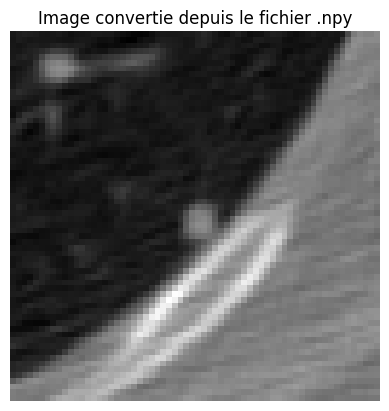

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Charger le fichier .npy
file_path = '/content/drive/MyDrive/luna16_data_backup/dernierdata/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987_z187_nodule.npy'
data = np.load(file_path)

# Vérifier la forme du tableau
print("Shape du tableau:", data.shape)

# Afficher le tableau comme une image
plt.imshow(data, cmap='gray')
plt.title('Image convertie depuis le fichier .npy')
plt.axis('off')  # Ne pas afficher les axes
plt.show()


Shape du tableau: (64, 64)


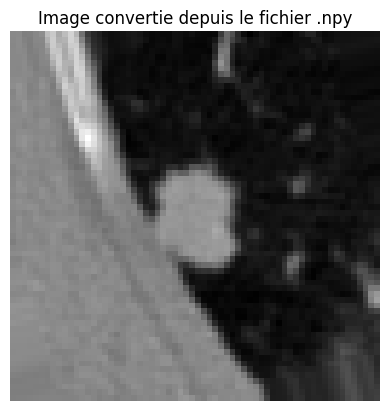

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Charger le fichier .npy
file_path = '/content/drive/MyDrive/luna16_data_backup/dernierdata/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097_z91_nodule_aug3.npy'
data = np.load(file_path)

# Vérifier la forme du tableau
print("Shape du tableau:", data.shape)

# Afficher le tableau comme une image
plt.imshow(data, cmap='gray')
plt.title('Image convertie depuis le fichier .npy')
plt.axis('off')  # Ne pas afficher les axes
plt.show()


In [ ]:
import os
import shutil
import random
from tqdm import tqdm

# 🔁 Pour des résultats reproductibles
random.seed(42)

# 📁 Dossier source
src_folder = "/content/drive/MyDrive/luna16_data_backup/dernierdata"
dst_root = "/content/drive/MyDrive/luna16_data_backup/dataset_split_VF"

# 📦 Charger les fichiers .npy
all_files = [f for f in os.listdir(src_folder) if f.endswith(".npy")]

# 🏷 Séparer par classes
positive_files = [f for f in all_files if "nodule" in f and "non_nodule" not in f]
negative_files = [f for f in all_files if "non_nodule" in f]

# 🎯 Ratio de split
train_ratio, val_ratio = 0.7, 0.15

def split_and_copy(files, label):
    random.shuffle(files)
    total = len(files)
    n_train = int(total * train_ratio)
    n_val = int(total * val_ratio)
    n_test = total - n_train - n_val

    splits = {
        "train": files[:n_train],
        "val": files[n_train:n_train+n_val],
        "test": files[n_train+n_val:]
    }

    for split_name, split_files in splits.items():
        split_dir = os.path.join(dst_root, split_name, label)
        os.makedirs(split_dir, exist_ok=True)
        for fname in tqdm(split_files, desc=f"{label} - {split_name}"):
            src = os.path.join(src_folder, fname)
            dst = os.path.join(split_dir, fname)
            shutil.copy(src, dst)

# 🔁 Appliquer le split
split_and_copy(positive_files, "positive")
split_and_copy(negative_files, "negative")

# ✅ Résumé
total = len(positive_files) + len(negative_files)
print("\n✅ Découpage terminé.")
print("📦 Total fichiers traités :", total)
print("📁 Dossier final :", dst_root)


negative - test: 100%|██████████| 135/135 [00:01<00:00, 73.41it/s]


✅ Découpage terminé.
📦 Total fichiers traités : 1792
📁 Dossier final : /content/drive/MyDrive/luna16_data_backup/dataset_split_VF


**✅Chargement & Préparation du Dataset**

In [ ]:
import os

base_dir = "/content/drive/MyDrive/luna16_data_backup/dataset_split_VF"
for split in ["train", "val", "test"]:
    for label in ["positive", "negative"]:
        path = os.path.join(base_dir, split, label)
        files = os.listdir(path)
        print(f"{split}/{label} : {len(files)} fichiers")


train/positive : 627 fichiers
train/negative : 627 fichiers
val/positive : 134 fichiers
val/negative : 134 fichiers
test/positive : 135 fichiers
test/negative : 135 fichiers


In [ ]:
import tensorflow as tf
import numpy as np
import os

# 📁 Dossier racine
dataset_dir = "/content/drive/MyDrive/luna16_data_backup/dataset_split_VF"

# 📌 Fonction pour charger un patch et retourner (image, label)
def load_npy(file_path, label):
    def _load(path):
        data = np.load(path.decode())  # decode: bytes ➜ str
        return data.astype(np.float32)

    image = tf.numpy_function(_load, [file_path], tf.float32)
    image.set_shape((64, 64))  # S’assurer que la shape est bien fixée
    return image, tf.cast(label, tf.int32)

# 📌 Fonction pour créer un dataset à partir d’un dossier
def create_dataset(folder_path, label):
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.npy')]
    labels = [label] * len(files)
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    ds = ds.map(lambda x, y: load_npy(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds

# 📦 Créer datasets
train_ds_pos = create_dataset(os.path.join(dataset_dir, "train", "positive"), 1)
train_ds_neg = create_dataset(os.path.join(dataset_dir, "train", "negative"), 0)
val_ds_pos   = create_dataset(os.path.join(dataset_dir, "val", "positive"), 1)
val_ds_neg   = create_dataset(os.path.join(dataset_dir, "val", "negative"), 0)
test_ds_pos  = create_dataset(os.path.join(dataset_dir, "test", "positive"), 1)
test_ds_neg  = create_dataset(os.path.join(dataset_dir, "test", "negative"), 0)

# 🔀 Mélanger et fusionner
train_ds = train_ds_pos.concatenate(train_ds_neg).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds_pos.concatenate(val_ds_neg).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds_pos.concatenate(test_ds_neg).batch(32).prefetch(tf.data.AUTOTUNE)

# ✅ Vérification
for images, labels in train_ds.take(1):
    print("✅ Exemple batch - Image shape:", images.shape, "| Labels:", labels.numpy())


✅ Exemple batch - Image shape: (32, 64, 64) | Labels: [0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0]


In [ ]:
import numpy as np
import os

# Chargement des données depuis les fichiers .npy
def load_dataset_from_folders(base_path):
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    for subset, X, y in [("train", X_train, y_train), ("val", X_val, y_val), ("test", X_test, y_test)]:
        for label in ["positive", "negative"]:
            folder = os.path.join(base_path, subset, label)
            if not os.path.exists(folder):
                continue
            for fname in os.listdir(folder):
                if fname.endswith(".npy"):
                    fpath = os.path.join(folder, fname)
                    patch = np.load(fpath)
                    X.append(patch)
                    y.append(1 if label == "positive" else 0)

    # Reshape + normalisation
    X_train = np.array(X_train).reshape(-1, 64, 64, 1).astype('float32') / 255.
    y_train = np.array(y_train)
    X_val = np.array(X_val).reshape(-1, 64, 64, 1).astype('float32') / 255.
    y_val = np.array(y_val)
    X_test = np.array(X_test).reshape(-1, 64, 64, 1).astype('float32') / 255.
    y_test = np.array(y_test)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Appliquer la fonction
base_dir = "/content/luna16/dataset_split_VF"
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_dataset_from_folders(base_dir)

# Vérification
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


X_train: (1254, 64, 64, 1) y_train: (1254,)
X_val: (268, 64, 64, 1) y_val: (268,)
X_test: (270, 64, 64, 1) y_test: (270,)


# Partie 2 : Modélisation


# 1er modele: Vision Transformer (ViT)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Paramètres du modèle ViT
input_shape = (64, 64, 1)  # Taille de l'entrée (image)
patch_size = 8  # Taille des patches
projection_dim = 64  # Dimension de la projection
num_heads = 4  # Nombre de têtes d'attention
transformer_units = [128, 64]  # Dimensions des unités des transformers
transformer_layers = 4  # Nombre de couches transformer
mlp_head_units = [128, 64]  # Unités des couches MLP pour la tête de classification

# Calcul dynamique du nombre de patches
num_patches = (input_shape[0] // patch_size) ** 2

# Construire le modèle Vision Transformer (ViT)
inputs = layers.Input(shape=input_shape)

# Extraction des patches avec tf.image.extract_patches
patches = layers.Reshape(target_shape=(num_patches, patch_size * patch_size))(inputs)

# Encodage des patches
x = layers.Dense(units=projection_dim)(patches)
x = layers.LayerNormalization(epsilon=1e-6)(x)

# Couches Transformer
for _ in range(transformer_layers):
    x1 = layers.LayerNormalization(epsilon=1e-6)(x)
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
    x2 = layers.Add()([attention_output, x])  # Résidus
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = layers.Dense(transformer_units[0], activation='relu')(x3)
    x3 = layers.Dense(transformer_units[1], activation='relu')(x3)
    x = layers.Add()([x3, x2])  # Résidus

x = layers.LayerNormalization(epsilon=1e-6)(x)

# Utilisation de GlobalAveragePooling1D pour réduire les dimensions
x = layers.GlobalAveragePooling1D()(x)

# Couches MLP pour classification
for units in mlp_head_units:
    x = layers.Dense(units, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

# Créer le modèle
vit_model = Model(inputs=inputs, outputs=outputs)

# Compilation du modèle
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Résumé du modèle
vit_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 64, 64)    │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64, 64)    │      4,160 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ dense_12[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ layer_normalizat… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 64, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64, 64)    │      8,256 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 64, 64)    │          0 │ dense_14[0][0],   │
│                     │                   │            │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 64, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64, 64)    │      8,256 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 64, 64)    │          0 │ dense_16[0][0],   │
│                     │                   │            │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_11[0][0]    

 Total params: 353,857 (1.35 MB)

 Trainable params: 353,857 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping

# Paramètres
batch_size = 32
img_size = (64, 64)  # Taille de l'image
data_dir = '/content/drive/MyDrive/luna16_data_backup/dataset_split_VF'  # Chemin vers ton dataset

# Chargement manuel des fichiers .npy pour l'entraînement
x_train, y_train = [], []
for label, class_name in enumerate(['negative', 'positive']):
    folder = os.path.join(data_dir, 'train', class_name)
    for file in os.listdir(folder):
        if file.endswith('.npy'):
            path = os.path.join(folder, file)
            x_train.append(np.load(path))
            y_train.append(label)

# Chargement des données de validation
x_val, y_val = [], []
for label, class_name in enumerate(['negative', 'positive']):
    folder = os.path.join(data_dir, 'val', class_name)
    for file in os.listdir(folder):
        if file.endswith('.npy'):
            path = os.path.join(folder, file)
            x_val.append(np.load(path))
            y_val.append(label)

# Chargement des données de test
x_test, y_test = [], []
for label, class_name in enumerate(['negative', 'positive']):
    folder = os.path.join(data_dir, 'test', class_name)
    for file in os.listdir(folder):
        if file.endswith('.npy'):
            path = os.path.join(folder, file)
            x_test.append(np.load(path))
            y_test.append(label)

# Conversion en tableaux et shuffle
x_train, y_train = shuffle(np.array(x_train), np.array(y_train), random_state=42)
x_val, y_val = shuffle(np.array(x_val), np.array(y_val), random_state=42)
x_test, y_test = shuffle(np.array(x_test), np.array(y_test), random_state=42)

# Normalisation
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Création des datasets TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Early stopping pour éviter le surapprentissage
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entraîner le modèle
history = vit_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,  # Nombre d'époques initiales
    callbacks=[early_stopping]
)

# Enregistrement du modèle
vit_model.save('/content/drive/MyDrive/luna16_data_backup/Model_Luna16_final/vit_model_final.keras')

# Évaluer le modèle sur le jeu de test
test_loss, test_acc = vit_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")


Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 395ms/step - accuracy: 0.5139 - loss: 0.7069 - val_accuracy: 0.6157 - val_loss: 0.6763
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 501ms/step - accuracy: 0.5385 - loss: 0.6824 - val_accuracy: 0.6791 - val_loss: 0.6655
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - accuracy: 0.5930 - loss: 0.6734 - val_accuracy: 0.6716 - val_loss: 0.6533
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 327ms/step - accuracy: 0.6423 - loss: 0.6495 - val_accuracy: 0.7015 - val_loss: 0.6213
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 323ms/step - accuracy: 0.6322 - loss: 0.6376 - val_accuracy: 0.7164 - val_loss: 0.5986
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 307ms/step - accuracy: 0.6681 - loss: 0.6164 - val_accuracy: 0.7052 - val_loss: 0.5891
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 313ms/step - accuracy: 0.6843 - loss: 0.5955 - val_accuracy: 0.7239 - val_loss: 0.5922
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 314ms/step - accuracy: 0.7453 - loss: 0.5539 - val_accu

In [ ]:
import os
import numpy as np

# Paramètres
batch_size = 32
img_size = (64, 64)  # Taille de l'image
data_dir = '/content/drive/MyDrive/luna16_data_backup/dataset_split_VF'  # Chemin vers ton dataset

# Chargement manuel des fichiers .npy pour le test (changement de 'train' par 'test')
x_test, y_test = [], []
for label, class_name in enumerate(['negative', 'positive']):
    folder = os.path.join(data_dir, 'test', class_name)  # Change 'train' par 'test'
    for file in os.listdir(folder):
        if file.endswith('.npy'):
            path = os.path.join(folder, file)
            x_test.append(np.load(path))
            y_test.append(label)

# Convertir en arrays numpy
x_test = np.array(x_test)
y_test = np.array(y_test)

# Vérification de la taille des données de test
print(f'Taille des données de test : {x_test.shape}, Taille des étiquettes de test : {y_test.shape}')


Taille des données de test : (270, 64, 64), Taille des étiquettes de test : (270,)


In [ ]:
from tensorflow.keras.models import load_model

vit_model = load_model('/content/drive/MyDrive/luna16_data_backup/Model_Luna16_final/vit_model_final.keras')


In [ ]:
# Si tes images sont en niveaux de gris, il faut ajouter une dimension pour le canal (1)
x_test = np.expand_dims(x_test, axis=-1)  # Ajoute la dimension du canal (1)

# Vérification de la nouvelle forme des données
print(f'Nouvelle forme des données de test : {x_test.shape}')

# Évaluation du modèle avec les données de test
test_loss, test_accuracy = vit_model.evaluate(x_test, y_test, batch_size=batch_size)

# Affichage des résultats de l'évaluation
print(f'Perte de test : {test_loss}')
print(f'Précision de test : {test_accuracy}')


Nouvelle forme des données de test : (270, 64, 64, 1, 1)
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.8157 - loss: 0.4212
Perte de test : 0.3908597230911255
Précision de test : 0.8333333134651184


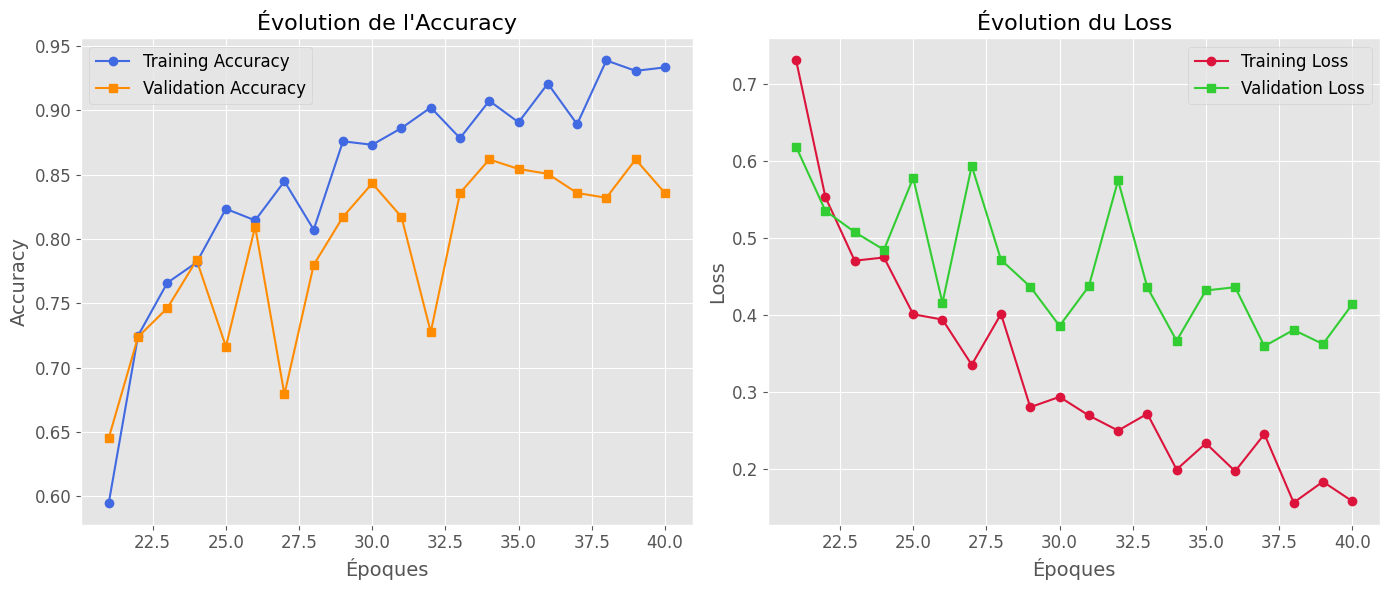

In [ ]:
import matplotlib.pyplot as plt

# Tracer la courbe de l'accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy (entrainement)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)')
plt.title('Courbe de l\'Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Tracer la courbe du loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss (entrainement)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.title('Courbe du Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Afficher les courbes
plt.tight_layout()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step


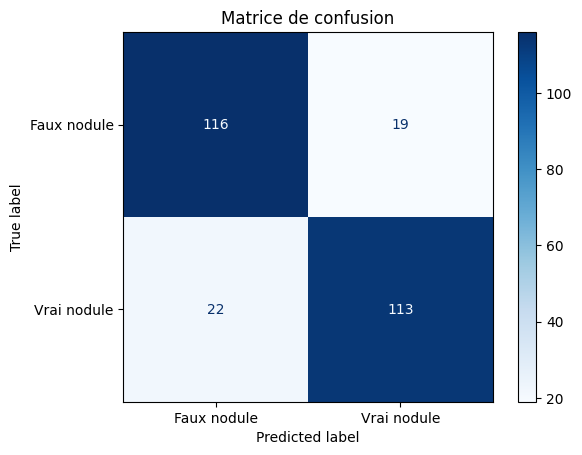


Rapport de classification :
              precision    recall  f1-score   support

 Faux nodule       0.84      0.86      0.85       135
 Vrai nodule       0.86      0.84      0.85       135

    accuracy                           0.85       270
   macro avg       0.85      0.85      0.85       270
weighted avg       0.85      0.85      0.85       270



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Prédictions sur les données de test
y_pred_prob = vit_model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()  # Binarisation des probabilités

# Affichage de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Faux nodule", "Vrai nodule"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()

# Rapport de classification
print("\nRapport de classification :")
print(classification_report(y_test, y_pred, target_names=["Faux nodule", "Vrai nodule"]))


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step


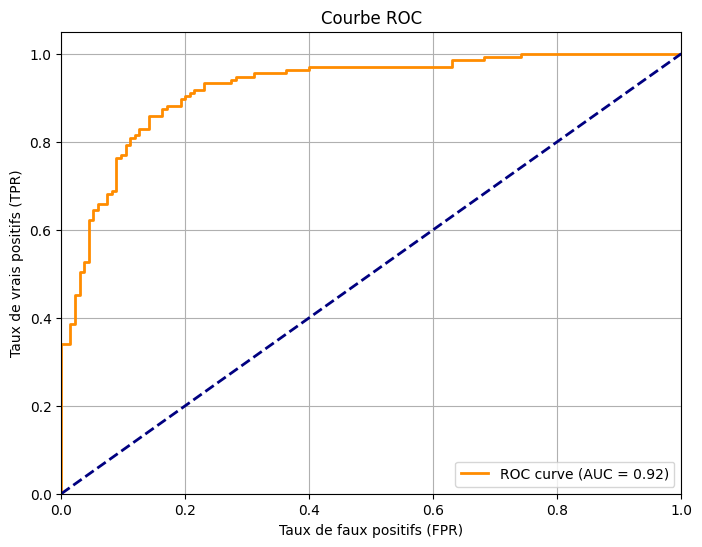

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Prédictions de probabilité pour chaque classe (on veut les scores, pas les classes directement)
y_pred_proba = vit_model.predict(x_test)

# On prend les probabilités pour la classe "positive" (indice 1)
# Si la sortie est de forme (270, 2), on prend [:, 1]
# Si la sortie est de forme (270, 1), on prend directement [:, 0]
if y_pred_proba.shape[1] == 2:
    y_scores = y_pred_proba[:, 1]
else:
    y_scores = y_pred_proba[:, 0]

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Affichage
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # ligne diagonale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


##2 eme model :Xception##

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Chemin vers ton dataset
base_dir = "/content/drive/MyDrive/luna16_data_backup/dataset_split_VF"

# Fonction pour charger les fichiers .npy dans des tableaux numpy
def load_data_np(base_dir):
    def load_subset(subset):
        X, y = [], []
        for label in ['positive', 'negative']:
            label_dir = os.path.join(base_dir, subset, label)
            for fname in os.listdir(label_dir):
                img = np.load(os.path.join(label_dir, fname))
                X.append(img)
                y.append(1 if label == 'positive' else 0)
        return np.array(X), np.array(y)

    x_train, y_train = load_subset("train")
    x_val, y_val     = load_subset("val")
    x_test, y_test   = load_subset("test")

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

# Chargement des données
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data_np(base_dir)

# Convertir les images en 3 canaux (si elles sont en gris, on les duplique pour créer des images RGB)
x_train = np.stack([x_train] * 3, axis=-1)  # Dupliquer pour créer des images RGB
x_val = np.stack([x_val] * 3, axis=-1)
x_test = np.stack([x_test] * 3, axis=-1)

# Redimensionner les images à 71x71
x_train = tf.image.resize(x_train, (71, 71))
x_val = tf.image.resize(x_val, (71, 71))
x_test = tf.image.resize(x_test, (71, 71))

# Normalisation des images (valeurs entre 0 et 1)
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

# Modèle Xception
input_shape = (71, 71, 3)  # Taille des images ajustée pour Xception

# Charger Xception pré-entraîné sans les couches de classification
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

# Congeler les 2 premières couches et entraîner les autres
base_model.trainable = False
for layer in base_model.layers[:100]:
    layer.trainable = False

# Ajouter de nouvelles couches pour la classification
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Dropout pour éviter l'overfitting
outputs = layers.Dense(1, activation='sigmoid')(x)  # Classification binaire (nodules vs non-nodules)

# Créer le modèle final
model = models.Model(inputs=base_model.input, outputs=outputs)

# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Afficher un résumé du modèle
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 71, 71, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 35, 35,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 35, 35,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 35, 35,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 33, 33,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 33, 33,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 33, 33,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 33, 33,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 33, 33,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 33, 33,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 33, 33,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 33, 33,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 17, 17,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 17, 17,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 17, 17,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 17, 17,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 17, 17,    │          0 │ add[0][0]       

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Définir les callbacks pour l'entraînement
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/luna16_data_backup/Model_Luna16_final/Xception_model.keras',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='min')

# Entraînement du modèle sans augmentation des données
history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5276 - loss: 1.5318 - val_accuracy: 0.7164 - val_loss: 0.5623
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6814 - loss: 0.5933 - val_accuracy: 0.7873 - val_loss: 0.5103
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7080 - loss: 0.5539 - val_accuracy: 0.7724 - val_loss: 0.5097
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7210 - loss: 0.5343 - val_accuracy: 0.8246 - val_loss: 0.4447
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7484 - loss: 0.5019 - val_accuracy: 0.8172 - val_loss: 0.4702
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 79s 995ms/step - accuracy: 0.7351 - loss: 0.5062 - val_accuracy: 0.7500 - val_loss: 0.4660
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7501 - loss: 0.4881 - val_accuracy: 0.7948 - val_loss: 0.4297
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7840 - loss: 0.4577 - val_accuracy: 0.8246 - val_lo

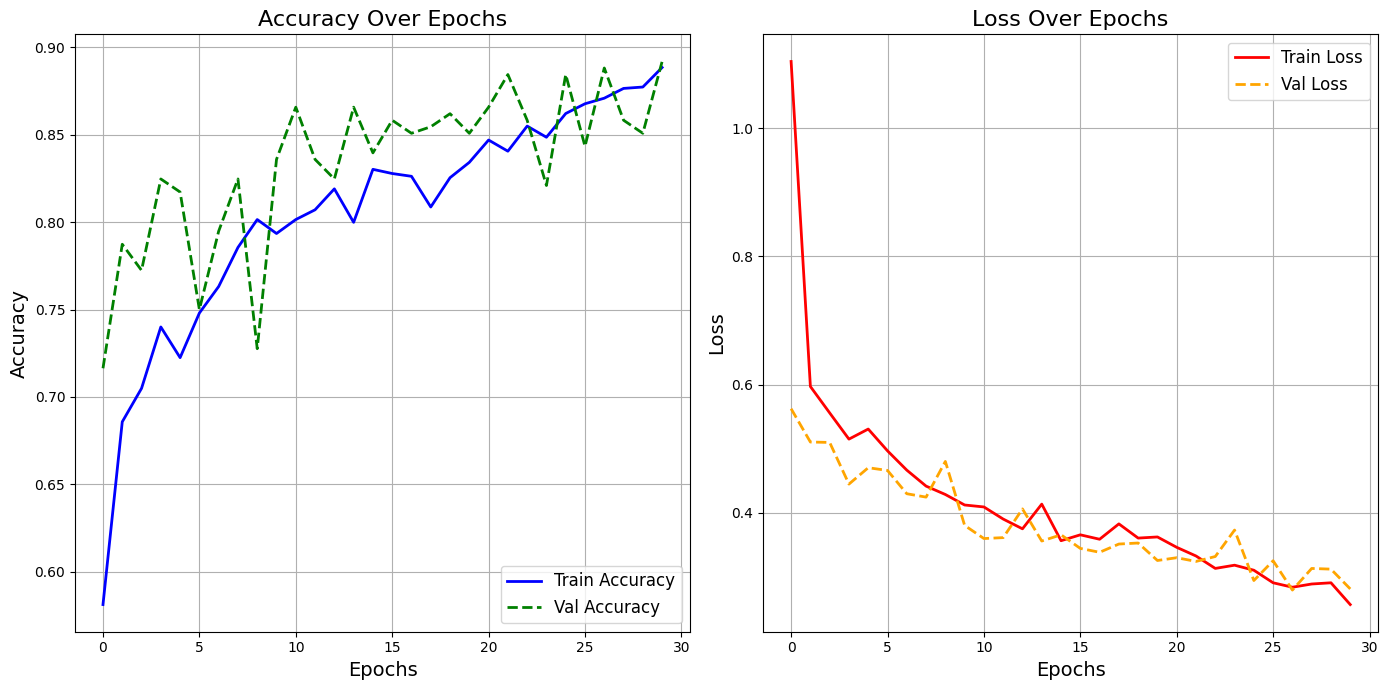

In [ ]:
import matplotlib.pyplot as plt

# Enregistrer l'historique pour afficher les courbes
history_dict = history.history

# Améliorer l'affichage avec des couleurs et un style plus distinct
plt.figure(figsize=(14, 7))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy', color='blue', linestyle='-', linewidth=2)
plt.plot(history_dict['val_accuracy'], label='Val Accuracy', color='green', linestyle='--', linewidth=2)
plt.title('Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss', color='red', linestyle='-', linewidth=2)
plt.plot(history_dict['val_loss'], label='Val Loss', color='orange', linestyle='--', linewidth=2)
plt.title('Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)

# Ajuster l'espacement entre les sous-graphes
plt.tight_layout()
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


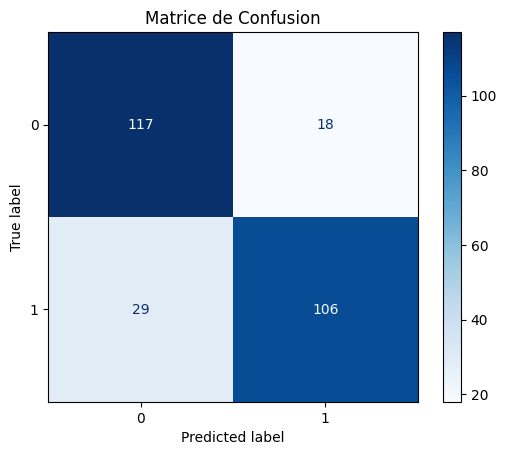

In [ ]:

# Calculer la matrice de confusion
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convertir les probabilités en classes

cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Matrice de Confusion')
plt.show()

In [ ]:
# Évaluation du modèle sur les données de test
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7960 - loss: 0.3543
Test Accuracy: 0.8259259462356567
Test Loss: 0.38766682147979736


In [ ]:
from sklearn.metrics import classification_report

# Rapport de classification (Precision, Recall, F1-Score)
report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       135
           1       0.85      0.79      0.82       135

    accuracy                           0.83       270
   macro avg       0.83      0.83      0.83       270
weighted avg       0.83      0.83      0.83       270



##3me model : CNN Classique##

In [ ]:
import numpy as np

# Convertir les images en 3 canaux (RGB)
x_train = np.repeat(x_train, 3, axis=-1)  # Répéter pour créer des images RGB
x_val = np.repeat(x_val, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)

# Normalisation des images (valeurs entre 0 et 1)
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

# Vérification des dimensions des données
print(f"Train images shape: {x_train.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Validation images shape: {x_val.shape}")
print(f"Validation labels shape: {y_val.shape}")


Train images shape: (1254, 64, 64, 9)
Train labels shape: (1254,)
Validation images shape: (268, 64, 64, 9)
Validation labels shape: (268,)


In [ ]:
# Définition du modèle
input_shape = x_train.shape[1:]  # (hauteur, largeur, canaux)
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Affichage du résumé du modèle
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 685,057 (2.61 MB)

 Trainable params: 685,057 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_val, y_val)
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 371ms/step - accuracy: 0.5231 - loss: 0.6907 - val_accuracy: 0.6716 - val_loss: 0.6270
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.6672 - loss: 0.6250 - val_accuracy: 0.7090 - val_loss: 0.5660
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 260ms/step - accuracy: 0.7504 - loss: 0.5374 - val_accuracy: 0.7388 - val_loss: 0.5183
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 274ms/step - accuracy: 0.7979 - loss: 0.4710 - val_accuracy: 0.8134 - val_loss: 0.4627
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step - accuracy: 0.7892 - loss: 0.4459 - val_accuracy: 0.7575 - val_loss: 0.4978
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 253ms/step - accuracy: 0.8225 - loss: 0.3901 - val_accuracy: 0.8284 - val_loss: 0.3919
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.8710 - loss: 0.3040 - val_accuracy: 0.8582 - val_loss: 0.3515
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 269ms/step - accuracy: 0.8899 - loss: 0.2740 - val_accu

In [ ]:
# Enregistrer le modèle après l'entraînement
model.save('/content/drive/MyDrive/luna16_data_backup/Model_Luna16_final/CNN_Model.keras')

# Enregistrer l'historique pour pouvoir tracer les courbes plus tard
import pickle
with open('/content/drive/MyDrive/luna16_data_backup/Model_Luna16_final/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

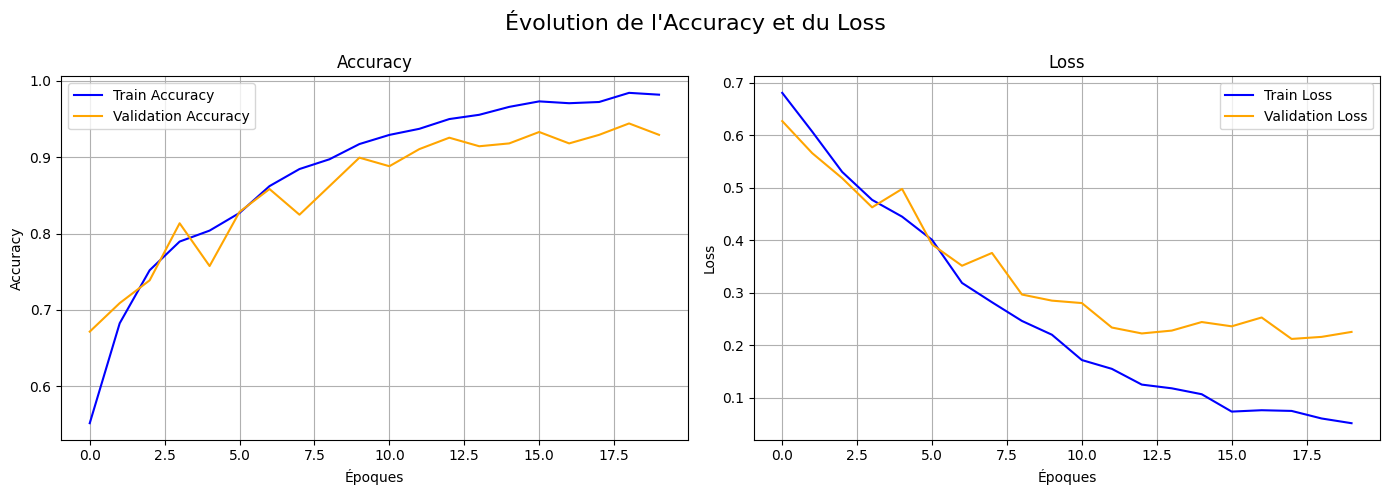

In [ ]:
# Charger l'historique à partir du fichier pickle
import pickle
import matplotlib.pyplot as plt

# Charger l'historique
with open('/content/drive/MyDrive/luna16_data_backup/Model_Luna16_final/training_history.pkl', 'rb') as f:
    history_dict = pickle.load(f)

# Définir la taille de la figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Courbe d'Accuracy
ax1.plot(history_dict['accuracy'], label='Train Accuracy', color='blue')
ax1.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='orange')
ax1.set_title('Accuracy')
ax1.set_xlabel('Époques')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Courbe de Loss
ax2.plot(history_dict['loss'], label='Train Loss', color='blue')
ax2.plot(history_dict['val_loss'], label='Validation Loss', color='orange')
ax2.set_title('Loss')
ax2.set_xlabel('Époques')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Afficher le titre principal
plt.suptitle('Évolution de l\'Accuracy et du Loss', fontsize=16)

# Ajuster les sous-graphes pour un meilleur espacement
plt.tight_layout()
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


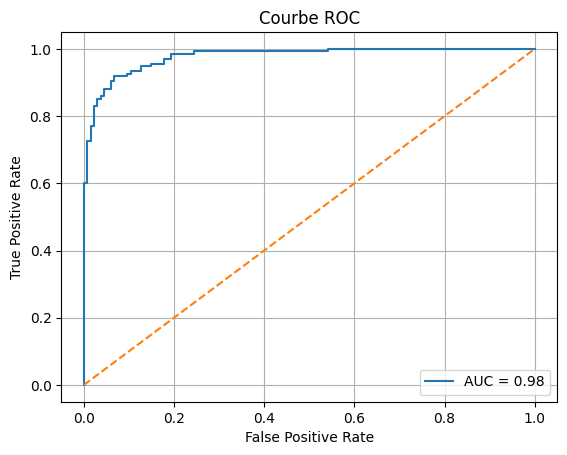

In [ ]:
from sklearn.metrics import roc_curve, auc

# Prédictions sur test
y_pred_proba = model.predict(x_test).ravel()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('Courbe ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


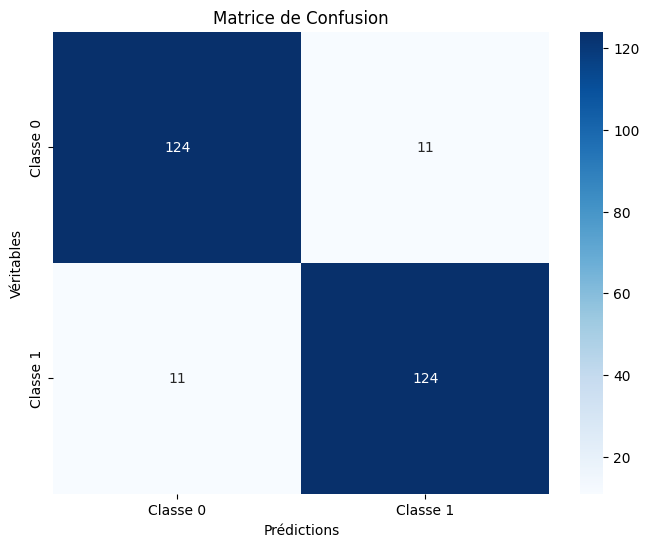

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       135
           1       0.92      0.92      0.92       135

    accuracy                           0.92       270
   macro avg       0.92      0.92      0.92       270
weighted avg       0.92      0.92      0.92       270



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Prédictions sur l'ensemble de test
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convertir les prédictions en classes (0 ou 1)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_classes)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.show()

# Rapport de classification (Precision, Recall, F1-Score)
report = classification_report(y_test, y_pred_classes)
print("Rapport de Classification :")
print(report)


In [ ]:
# Évaluer le modèle sur les données de test
test_loss, test_acc = model.evaluate(x_test, y_test)

# Afficher les résultats de l'évaluation
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9204 - loss: 0.2024
Test Loss: 0.21613329648971558
Test Accuracy: 0.9185185432434082


## 4 **eme** model :EfficientNetB0

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

# Chemin vers ton dataset
base_dir = "/content/drive/MyDrive/luna16_data_backup/dataset_split_VF"

# Fonction pour charger les fichiers .npy dans des tableaux numpy
def load_data_np(base_dir):
    def load_subset(subset):
        X, y = [], []
        for label in ['positive', 'negative']:
            label_dir = os.path.join(base_dir, subset, label)
            for fname in os.listdir(label_dir):
                img = np.load(os.path.join(label_dir, fname))
                X.append(img)
                y.append(1 if label == 'positive' else 0)
        return np.array(X), np.array(y)

    x_train, y_train = load_subset("train")
    x_val, y_val     = load_subset("val")
    x_test, y_test   = load_subset("test")

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

# Chargement
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data_np(base_dir)


In [ ]:
import numpy as np
# Convertir les images en 3 canaux
x_train = np.stack([x_train] * 3, axis=-1)  # Dupliquer pour créer des images RGB
x_val = np.stack([x_val] * 3, axis=-1)
x_test = np.stack([x_test] * 3, axis=-1)

# Normalisation des images (valeurs entre 0 et 1)
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

# Vérification des dimensions des données
print(f"Train images shape: {x_train.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Validation images shape: {x_val.shape}")
print(f"Validation labels shape: {y_val.shape}")


Train images shape: (1254, 64, 64, 3)
Train labels shape: (1254,)
Validation images shape: (268, 64, 64, 3)
Validation labels shape: (268,)


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Charger EfficientNetB0 sans la dernière couche de classification
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=x_train.shape[1:]
)

# Geler toutes les couches de EfficientNetB0
base_model.trainable = False

# Dé-geler les 20 dernières couches pour du fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Ajouter nos propres couches
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)  # L2 régularisation
x = Dropout(0.3)(x)  # Dropout pour éviter l'overfitting (0.3 au lieu de 0.5 pour être plus doux)
output = Dense(1, activation='sigmoid')(x)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=output)

# Compiler le modèle avec un learning rate scheduler
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=5000,  # J'ai diminué decay_steps pour qu'il commence à baisser plus tôt
    decay_rate=0.96,
    staircase=True
)

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,        # Arrête si pas d'amélioration après 5 epochs
    restore_best_weights=True,  # Remet les meilleurs poids obtenus
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Résumé du modèle
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 64, 64, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 64, 64, 3) │          7 │ rescaling[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 64, 64, 3) │          0 │ normalization[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 65, 65, 3) │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 32, 32,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 32, 32,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 32, 32,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 32, 32,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 32, 32,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 32, 32,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 32, 32,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 32, 32,    │        512 │ block1a_se_excit

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 1,515,057 (5.78 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveiller la perte de validation
    patience=3,          # Attendre 3 epochs sans amélioration avant d'arrêter
    restore_best_weights=True  # Restaurer les meilleurs poids du modèle
)


In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(x_val, y_val),
    # callbacks=[early_stopping]  # PAS de reduce_lr ici !
)


Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 372ms/step - accuracy: 0.5624 - loss: 0.7361 - val_accuracy: 0.4627 - val_loss: 0.7270
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - accuracy: 0.7033 - loss: 0.5723 - val_accuracy: 0.4664 - val_loss: 0.7144
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 279ms/step - accuracy: 0.7734 - loss: 0.4986 - val_accuracy: 0.5112 - val_loss: 0.6619
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.8010 - loss: 0.4505 - val_accuracy: 0.6866 - val_loss: 0.5852
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 296ms/step - accuracy: 0.8510 - loss: 0.3794 - val_accuracy: 0.7649 - val_loss: 0.5018
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 277ms/step - accuracy: 0.8572 - loss: 0.3598 - val_accuracy: 0.8433 - val_loss: 0.4118
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 285ms/step - accuracy: 0.8928 - loss: 0.3112 - val_accuracy: 0.8545 - val_loss: 0.3652
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.9010 - loss: 0.3005 - val_accu

In [ ]:
# Sauvegarder le modèle
model.save('/content/drive/MyDrive/luna16_data_backup/Model_Luna16_final/efficient_model.keras')

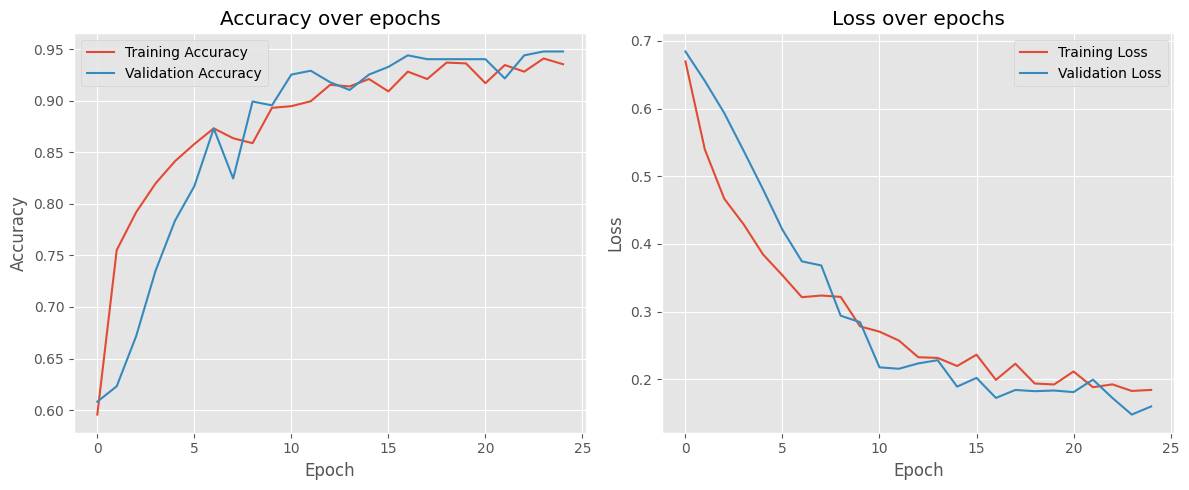

In [ ]:
import matplotlib.pyplot as plt

# Courbe de l'accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Courbe de la loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9335 - loss: 0.1494
Test Loss: 0.1760065257549286
Test Accuracy: 0.9296296238899231
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 729ms/step


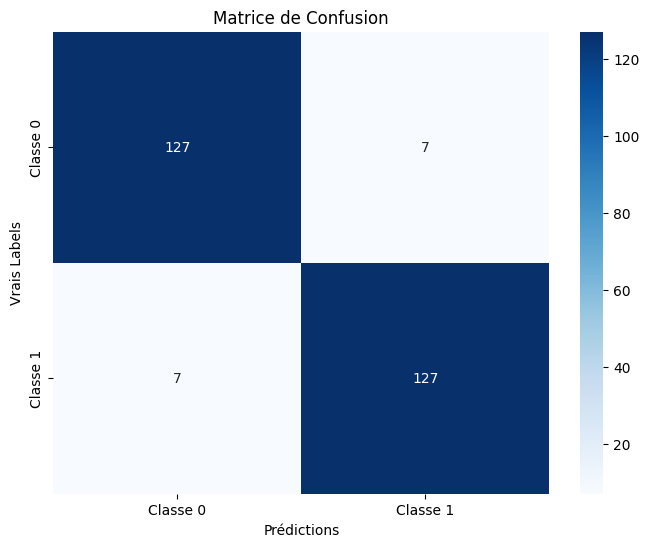

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Charger le modèle sauvegardé
model = load_model('/content/drive/MyDrive/luna16_data_backup/Model_Luna16_final/efficient_model.keras')

# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(x_test, y_test)

# Afficher la perte et l'exactitude sur l'ensemble de test
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Faire des prédictions sur les données de validation (x_val)
predictions = model.predict(x_val)  # x_val est déjà normalisé

# Si c'est une classification binaire, nous devons convertir les probabilités en classes (0 ou 1)
predicted_classes = (predictions > 0.5).astype("int32")  # Seuil de 0.5 pour classification binaire

# Calculer la matrice de confusion
cm = confusion_matrix(y_val, predicted_classes)

# Visualiser la matrice de confusion avec Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vrais Labels')
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step


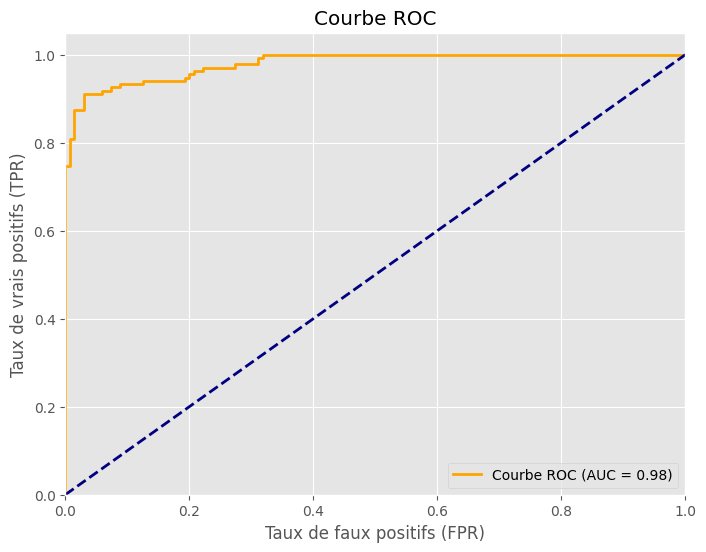

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Prédictions sur l'ensemble de test
y_prob = model.predict(x_test).flatten()

# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)  # y_test est l'étiquette réelle pour l'ensemble de test
roc_auc = auc(fpr, tpr)  # Calcul de l'AUC

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# 🔥 Comparatif des Performances des Modèles


In [8]:
import pandas as pd
from IPython.display import display, HTML

# Dictionnaire des données
data = {
    "Critère": ["Accuracy (Test)", "Loss (Test)", "Précision (Classe 0)", "Recall (Classe 0)", "F1-Score (Classe 0)",
                "Précision (Classe 1)", "Recall (Classe 1)", "F1-Score (Classe 1)", "Macro Avg (F1-Score)", "Temps d'Inférence"],
    "Xception": ["82.59 %", "0.3877", "80 %", "87 %", "83 %", "85 %", "79 %", "82 %", "83 %", "11 sec"],
    "ViT": ["83.33 %", "0.3909", "84 %", "86 %", "85 %", "86 %", "84 %", "85 %", "85 %", "5 sec"],
    "EfficientNet": ["92.96 %", "0.1760", "94.07 %", "94.07 %", "94.07 %", "94.07 %", "94.07 %", "94.07 %", "94.07 %", "8 sec"],
    "CNN": ["91.85 %", "0.2161", "92 %", "92 %", "92 %", "92 %", "92 %", "92 %", "92 %", "1 sec"]
}

# Création du DataFrame
df = pd.DataFrame(data)

# Affichage avec Pandas
display(df)


Critère Xception      ViT EfficientNet      CNN
0       Accuracy (Test)  82.59 %  83.33 %      92.96 %  91.85 %
1           Loss (Test)   0.3877   0.3909       0.1760   0.2161
2  Précision (Classe 0)     80 %     84 %      94.07 %     92 %
3     Recall (Classe 0)     87 %     86 %      94.07 %     92 %
4   F1-Score (Classe 0)     83 %     85 %      94.07 %     92 %
5  Précision (Classe 1)     85 %     86 %      94.07 %     92 %
6     Recall (Classe 1)     79 %     84 %      94.07 %     92 %
7   F1-Score (Classe 1)     82 %     85 %      94.07 %     92 %
8  Macro Avg (F1-Score)     83 %     85 %      94.07 %     92 %
9     Temps d'Inférence   11 sec    5 sec        8 sec    1 sec

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('ViT').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('EfficientNet').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('CNN').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['EfficientNet'].value_counts()
    for x_label, grp in df.groupby('ViT')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('ViT')
_ = plt.ylabel('EfficientNet')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['CNN'].value_counts()
    for x_label, grp in df.groupby('EfficientNet')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('EfficientNet')
_ = plt.ylabel('CNN')

✨ Résumé :
🔥 EfficientNet est le meilleur modèle global (plus haute accuracy, meilleur f1-score, plus faible loss).

⚡ CNN est le plus rapide (temps d'inférence minimal) avec une excellente précision.

🔥 ViT surpasse légèrement Xception en accuracy et en f1-score.

🧠 Xception reste correct mais en retrait par rapport aux autres.



In [26]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1Qp2bmoacyxBx7bUsuvX1WHWEa4zG73OSBYtwl-EXA-0/edit#gid=0


✅Conclusion:

EfficientNet est le meilleur sur tous les critères (accuracy, loss, précision, recall, f1-score).

CNN est plus rapide mais légèrement moins bon que EfficientNet.

ViT est un peu meilleur que Xception, mais ils restent loin de EfficientNet et CNN.